# Generative Adversarial Networks and MNIST

Generative adversarial networks are actually a combination of two neural networks called the Generator and Discriminator:

![GAN Diagram](assets/GAN_diagram.jpg)

The input for the discriminator is always either a sample from the training data, or a sample created by the generator. Using this setup, the discriminator is typically a binary classifier: Its job is to classify samples as real examples (i.e. samples from the training set) or fake examples (i.e. examples created by the generator). The generator's job, then, is to produce data that realistically mimics samples from the training set. In order to force the generator to create many different samples we provide random noise as input to the generator. 

In this notebook, the real samples will be handwritten digits from the MNIST dataset, and we'll train a generator that  creates (somewhat) realistic digits.

## Preparing The Data

Like every other situation we've encoutered so far, we're going to perform some preprocessing on the image data from MNIST to maximize performance and ensure our Keras model can handle the shapes properly.

In [1]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam

import numpy as np

from matplotlib import pyplot as plt

# This is a bit different than we're used to for other 
# MNIST networks we've built. Note that we don't care
# at all about the "class" — we are NOT trying to identify
# digits. We're only trying to make passable fakes.
(real_train_images, _), (real_test_images, _) = load_data()

In [2]:
# Some people suggest swapping the label value from
# what is usual, i.e. using 1 for fake and 0 for real
# in order to improve the training process. These 
# allow you to play around with that.
REAL_LABEL_VALUE = 0
FAKE_LABEL_VALUE = 1

In [3]:
# We have to do some slight processing of the MNIST input images.
# Specifically, keras expects 3 dimentional input, 
# height, width, and color channels.

# since we have black/white images we just use np.expand_dims
# to go from (28, 28) => (28, 28, 1). This should feel familiar,
# if you've used CNNs in keras at all.

# We're also going to normalize from the 0-255 domain to 0.0-1.0
def prepare_real_samples(samples):
    prepared_samples = np.expand_dims(samples, axis=-1)
    prepared_samples = prepared_samples.astype('float32')
    prepared_samples = prepared_samples / 255.0
    
    return prepared_samples


# Because the network is trained on the binary question
# "real" or "fake" this helper function selects a number 
# of samples from a set of samples that has already been
# "prepared" by the previous function. 

# We select a random sample, and provide the label
# for each of the selected samples.

# Crucially, we ASSUME that "samples" is a set of real
# examples prepared with prepare_real_samples. It is possible
# to pass fake/generated samples to this function, but that
# would be very bad for our GAN. 
def generate_real_batch(samples, n_samples):
    indices = np.random.randint(0, samples.shape[0], n_samples)
    batch_images = samples[indices]
    batch_labels = np.full((n_samples, 1), REAL_LABEL_VALUE)

    return batch_images, batch_labels


# We're going to give our discriminator a head start
# by allowing it to train, on its own, against totally
# random noise. 

# Later, we'll add a generator network and train
# the discriniator against the output of that network.
# This function generates a number of images.
def generate_random_fake_batch(n_samples, shape=(28,28,1)):
    # Random numbers 0.0-1.0 from a uniform distribution in a flat numpy Array
    batch = np.random.rand(shape[0] * shape[1] * shape[2] * n_samples)
    
    # Unflatten the list according to the provided shape
    batch = batch.reshape((n_samples, shape[0], shape[1], shape[2]))

    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)
    return batch, labels

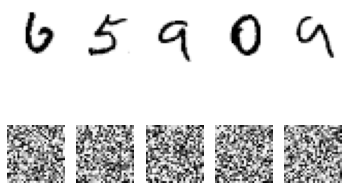

In [4]:
# Prepare the dataset
prepared_real_images = prepare_real_samples(real_train_images)

# Lets quickly visualize our "real" data vs our "fake" data.
real_x, _ = generate_real_batch(prepared_real_images, 5)
fake_x, _ = generate_random_fake_batch(5)

all_x = np.concatenate((real_x, fake_x))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(all_x[i, :, :, 0], cmap='Greys')


## The Discriminator

The Discriminator is a CNN, a binary classifier, and in our case relatively simple. Before we move on to building the generator we're going to do a "gut check" on our discriminator architecture by checking that it can tell the difference between randomly generated noise, and digits from the MNIST dataset. 

In [5]:
# The discriminator accepts an image as input. The image is
# either a real example, or a generated one. The discriminator
# makes a binary decision about which it is, real or false.

# The default input shape is selected to match the MNIST dataset
# and could be changed to support other datasets.

# This simple network will be satisfactory for the simple MNIST dataset.
# Leaky, 2x2 striding, dropout, and batch normalization are all 
# suggested best practices for GAN .

def create_discriminator(in_shape=(28,28,1)):
    model = Sequential()

    # 14x14
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # No strides, 14x14
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # 7x7
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Classification head
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Note the quite small learning rate.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
# Okay, lets put all that together by training our discriminator
# on real MNIST digits for the "real" and random noise for the "fake"

INPUT_SHAPE = (28, 28, 1) # MNIST specific
BATCH_SIZE = 256          # How many of EACH real/fake to train during each round?
BATCH_N = 5              # How many rounds? 

# Get a copy of the discriminator
discriminator_network = create_discriminator(INPUT_SHAPE)

# Each of these for loop iterations is analogous to a single epoch
# but we are getting a random sample of real images, and brand new
# noise vectors each epoch. Additionally, we're not seeing EVERY real
# sample on each epoch.
for current_round in range(BATCH_N):
    real_x, real_y = generate_real_batch(prepared_real_images, BATCH_SIZE)
    fake_x, fake_y = generate_random_fake_batch(BATCH_SIZE, INPUT_SHAPE)
    
    full_x = np.concatenate((real_x, fake_x))
    full_y = np.concatenate((real_y, fake_y))
    
    print(f"Round number {current_round}")
    discriminator_network.fit(full_x, full_y, batch_size=BATCH_SIZE, epochs=1, verbose=True)


Round number 0
Train on 512 samples
512/512 [==============================] - 1s 2ms/sample - loss: 0.6775 - accuracy: 0.6406
Round number 1
Train on 512 samples
512/512 [==============================] - 1s 998us/sample - loss: 0.6549 - accuracy: 0.6172
Round number 2
Train on 512 samples
512/512 [==============================] - 1s 984us/sample - loss: 0.6296 - accuracy: 0.5781
Round number 3
Train on 512 samples
512/512 [==============================] - 0s 897us/sample - loss: 0.5993 - accuracy: 0.5859
Round number 4
Train on 512 samples
512/512 [==============================] - 1s 993us/sample - loss: 0.5670 - accuracy: 0.5742


After 5*512 = 2560 samples, our discriminator can distinguish between random noise and real digits (reasonablly). If our discriminator could not do this relatively easily / quickly, we would want to revisit our architecture until it could. Remember, this is a very small number of samples for a neural network to have trained on (2560, compared to a single epoch of MNIST being ~60,000 samples.

## The Generator

In [7]:
# Generators need to recieve some random noise as the "seed" of their
# output. The amount of unique noise available to the network limits 
# the number of unique outputs the generator can create.

# Furthermore, we must transform this noise into a shape
# that our CNN can work with.

# Emperically, reseachers have had success with the strategy below
# for selecting the magnitude of this noise. Other tactics can also
# work. See the Resources for Further Exploration for more. 

# Our input shape is based on an arbitrary amount of noise.
# we'll use 100 below, but you can experiment with other values
# that also work well. 

# Our generator starts with a dense layer that should have enough nodes
# to represent several examples of a low-resolution version of our image. 
# Then, we iteratively upsample using Conv2DTranspose until
# we have images that are the right shape: (28, 28).
def create_generator(noise_dim, dense_layer_nodes):
    model = Sequential()

    model.add(Dense(dense_layer_nodes, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # No strides, 14x14
    model.add(Conv2DTranspose(128, (4,4), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Finally layer only has one filter and a wide convolution kernal.
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model


# We also need to generate a noise vector that matches 
# the noise shape we choose.
def generate_noise_vector(noise_dim, n_samples):
    noise_vector = np.random.randn(noise_dim * n_samples)
    noise_vector = noise_vector.reshape(n_samples, noise_dim)

    return noise_vector


# Finally, we need to be able to use the generator to 
# make a fake digit! Again, generate a batch and lables (all 0)
def generate_fake_batch(generator, noise_dim, n_samples):
    noise_vector = generate_noise_vector(noise_dim, n_samples)
    batch = generator.predict(noise_vector)
    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)

    return batch, labels

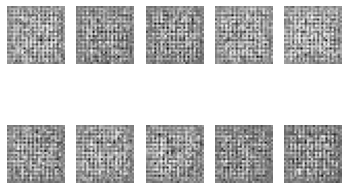

In [8]:
# Lets visualize some examples of the untrained fake
# images... they will probably still just look like 
# noise, but we can see how these functions work.

# 100 is arbitrary, but a commonly used value.
NOISE_DIM = 100

# This number should be a large enough space to represent
# "a handful of low resolution examples" of the images we're
# trying to generate. In our case, 7*7 is the "low resolution"
# (downsampled by a factor of 4, from 28 * 28 -> 7 * 7) and 128
# is "a handful".
DENSE_LAYER_SIZE = 128 * 7 * 7

# Increasing both or either the NOISE_DIM or DENSE_LAYER_SIZE will 
# increase the number of unique representations that our generator
# will ultimately generate. It will also increase the number of 
# parameters in the network of course, so it will increase training time.

generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)

fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

Wonderfully noisy. Now, how do we get this thing to produce fake digits?

## The "Generative Adversarial Network" and Training

As we mentioned, the GAN is actually a composition of both the generator and the discriminator, arranged sequentially. We need the output from the discriminator in order to train the GAN — the generator's performance is a function of its ability to trick the discrimintaor. Similarly, to train the discriminator, we need to send it samples from the generator **as well as** real samples from the training set.

Training a GAN is typically broken into three separate training processes:

1. Train the discriminator on a batch of real samples.
2. Train the discriminator on a batch of fake (generated) samples. 
3. Train the generator by freezing the discriminator and inverting the labels on generated images.

The discriminator and generator are NOT trained at the same time, instead they are trained iteratively in small batches. When the discriminator is learning, the generator's weights are not modified. When the generator is learning, the discriminators weigths are not modified. 

Lets see how this works:

In [9]:
def create_gan(generator, discriminator):
    # The output of the generator is the input to the discriminator.
    # The output of the discriminator matches our lables (0, 1) for (fake, real)
    model = Sequential()
    model.add(generator)

    # When the GAN trains, it only trains the generator.
    # the discriminator has to be trained separately. 
    # This honestly seems like the wrong way to do this...
    # But apparently it's totally legit: https://github.com/keras-team/keras/issues/8585
    discriminator.trainable = False
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


# A lot of work has gone into figuring out strategies
# for training GANs, and some of the best practices include:

# Freezing the discriminator while we train the generator, this
# creates a stable target for the generator to work against. 

# Periodically updating the discriminator BY ITSELF with batches
# of fake images from the generator and real images from the dataset. 

# Inverting the label of "fake" images during generator training. 
#   In order to fool the discriminator, we invert the labels.
#   The idea is that when the discrimiator is doing a GOOD job 
#   (i.e. low loss / error) we need to tell the generator that its
#   doing a BAD job. A very quick way to achieve this is to flip
#   labels when training the generator. 
def train_gan(gan, generator, discriminator, noise_dim, batches, batch_size, verbose=True):
    print("Training... \nDiscriminator Real Acc, Discriminator Fake Acc, Generator Acc")
    for i in range(batches):
        real_batch_images, real_batch_labels = generate_real_batch(prepared_real_images, batch_size // 2)
        fake_batch_images, fake_batch_labels = generate_fake_batch(generator, noise_dim, batch_size // 2)


        # Training a batch of real, then a batch of fake, rather than a shuffled mix
        # could impact training, but it gives us more granular information about the
        # discriminator's performance. 
        _, discriminator_real_acc = discriminator.train_on_batch(real_batch_images, real_batch_labels)
        _, discriminator_fake_acc = discriminator.train_on_batch(fake_batch_images, fake_batch_labels)
        
        
        # Make some noise for the full model to train on
        gan_input_vector = generate_noise_vector(noise_dim, batch_size)

        # In order to fool the discriminator, we invert the labels.
        # The idea is that when the discrimiator is doing a GOOD job 
        # (i.e. low loss / error) we need to tell the generator that its
        # doing a BAD job. A very quick way to achieve this is to flip
        # labels when training the generator. 
        gan_labels = np.full((batch_size, 1), REAL_LABEL_VALUE)
        _, gan_acc = gan.train_on_batch(gan_input_vector, gan_labels)
        
        if verbose: print(f"{i} / {batches}: {discriminator_real_acc}, {discriminator_fake_acc}, {gan_acc}")

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.484375, 0.0, 1.0
1 / 100: 0.9453125, 0.0, 1.0
2 / 100: 1.0, 0.0, 1.0
3 / 100: 1.0, 0.0, 1.0
4 / 100: 1.0, 0.0, 1.0
5 / 100: 1.0, 0.0, 1.0
6 / 100: 1.0, 0.0, 0.859375
7 / 100: 1.0, 0.1875, 0.078125
8 / 100: 1.0, 0.875, 0.0
9 / 100: 1.0, 1.0, 0.0
10 / 100: 1.0, 1.0, 0.0
11 / 100: 0.9921875, 0.6875, 0.01953125
12 / 100: 1.0, 0.0, 0.86328125
13 / 100: 0.9921875, 0.0, 0.99609375
14 / 100: 1.0, 0.0, 0.9921875
15 / 100: 1.0, 0.015625, 0.34375
16 / 100: 1.0, 0.71875, 0.00390625
17 / 100: 1.0, 1.0, 0.0
18 / 100: 1.0, 1.0, 0.0
19 / 100: 1.0, 0.1328125, 0.0078125
20 / 100: 1.0, 0.0, 1.0
21 / 100: 1.0, 0.0, 1.0
22 / 100: 1.0, 0.0, 1.0
23 / 100: 1.0, 0.0, 0.99609375
24 / 100: 1.0, 0.0234375, 0.08984375
25 / 100: 1.0, 0.9375, 0.0
26 / 100: 1.0, 1.0, 0.0
27 / 100: 0.9921875, 1.0, 0.0
28 / 100: 0.984375, 1.0, 0.0
29 / 100: 1.0, 0.9921875, 0.00390625
30 / 100: 0.9921875, 0.0859375, 0.41796875
31 / 100: 1.0, 0.0, 0.718

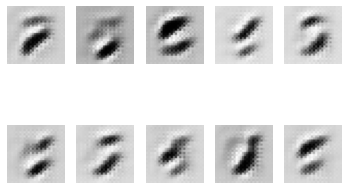

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8515625, 0.625, 0.125
1 / 100: 0.84375, 0.5546875, 0.08984375
2 / 100: 0.7578125, 0.6015625, 0.1328125
3 / 100: 0.828125, 0.5546875, 0.09765625
4 / 100: 0.8046875, 0.6875, 0.1484375
5 / 100: 0.71875, 0.625, 0.10546875
6 / 100: 0.71875, 0.6640625, 0.14453125
7 / 100: 0.7578125, 0.5, 0.12109375
8 / 100: 0.765625, 0.5390625, 0.17578125
9 / 100: 0.796875, 0.5234375, 0.171875
10 / 100: 0.71875, 0.5703125, 0.13671875
11 / 100: 0.7578125, 0.625, 0.2265625
12 / 100: 0.796875, 0.421875, 0.25390625
13 / 100: 0.8125, 0.46875, 0.265625
14 / 100: 0.75, 0.484375, 0.21484375
15 / 100: 0.7890625, 0.4765625, 0.20703125
16 / 100: 0.7734375, 0.5859375, 0.1640625
17 / 100: 0.734375, 0.6171875, 0.171875
18 / 100: 0.8515625, 0.46875, 0.1953125
19 / 100: 0.8203125, 0.53125, 0.23828125
20 / 100: 0.8515625, 0.5078125, 0.15625
21 / 100: 0.828125, 0.59375, 0.203125
22 / 100: 0.875, 0.5390625, 0.14453125
23 / 100: 0.8125, 0.5156

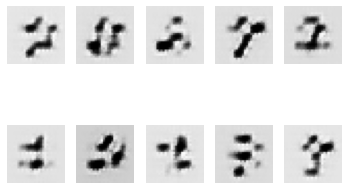

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.796875, 0.7265625, 0.0234375
1 / 100: 0.7265625, 0.90625, 0.00390625
2 / 100: 0.765625, 0.8828125, 0.0
3 / 100: 0.671875, 0.9375, 0.0
4 / 100: 0.6484375, 0.8046875, 0.00390625
5 / 100: 0.71875, 0.859375, 0.0234375
6 / 100: 0.6875, 0.9296875, 0.0
7 / 100: 0.7421875, 0.8984375, 0.01171875
8 / 100: 0.734375, 0.7265625, 0.05859375
9 / 100: 0.8125, 0.734375, 0.0234375
10 / 100: 0.8125, 0.890625, 0.0
11 / 100: 0.9140625, 0.7265625, 0.015625
12 / 100: 0.8046875, 0.8359375, 0.0078125
13 / 100: 0.8203125, 0.8828125, 0.0
14 / 100: 0.8359375, 0.828125, 0.01171875
15 / 100: 0.8359375, 0.875, 0.03125
16 / 100: 0.9140625, 0.984375, 0.0
17 / 100: 0.90625, 0.609375, 0.03515625
18 / 100: 0.9296875, 0.828125, 0.0234375
19 / 100: 0.921875, 0.859375, 0.00390625
20 / 100: 0.9296875, 0.8203125, 0.01953125
21 / 100: 0.8359375, 0.84375, 0.02734375
22 / 100: 0.859375, 0.828125, 0.015625
23 / 100: 0.8984375, 0.59375, 0.0507812

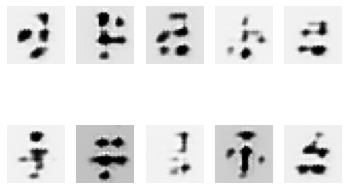

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8984375, 0.703125, 0.02734375
1 / 100: 0.828125, 0.609375, 0.03125
2 / 100: 0.9296875, 0.859375, 0.00390625
3 / 100: 0.859375, 0.8203125, 0.02734375
4 / 100: 0.921875, 0.6796875, 0.015625
5 / 100: 0.890625, 0.8203125, 0.01953125
6 / 100: 0.90625, 0.6796875, 0.0234375
7 / 100: 0.9296875, 0.7109375, 0.04296875
8 / 100: 0.9453125, 0.8359375, 0.01171875
9 / 100: 0.9140625, 0.7421875, 0.0234375
10 / 100: 0.875, 0.796875, 0.0
11 / 100: 0.9375, 0.46875, 0.04296875
12 / 100: 0.890625, 0.734375, 0.0078125
13 / 100: 0.8984375, 0.7734375, 0.00390625
14 / 100: 0.9296875, 1.0, 0.0
15 / 100: 0.84375, 0.8046875, 0.0078125
16 / 100: 0.84375, 0.96875, 0.0
17 / 100: 0.90625, 0.875, 0.0
18 / 100: 0.859375, 0.7734375, 0.01171875
19 / 100: 0.875, 0.90625, 0.0
20 / 100: 0.890625, 0.8515625, 0.00390625
21 / 100: 0.921875, 0.765625, 0.0078125
22 / 100: 0.96875, 0.921875, 0.0
23 / 100: 0.9609375, 0.6484375, 0.0078125
24 / 100

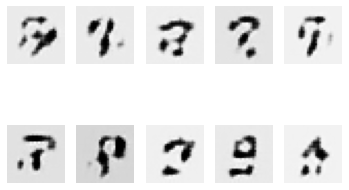

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.921875, 0.734375, 0.0
1 / 100: 0.8359375, 0.9375, 0.0
2 / 100: 0.828125, 0.8984375, 0.0
3 / 100: 0.921875, 0.828125, 0.0
4 / 100: 0.90625, 0.96875, 0.0
5 / 100: 0.8828125, 0.875, 0.00390625
6 / 100: 0.90625, 0.890625, 0.0
7 / 100: 0.8984375, 0.9765625, 0.0
8 / 100: 0.96875, 0.8515625, 0.0
9 / 100: 0.8984375, 0.9296875, 0.00390625
10 / 100: 0.921875, 0.8984375, 0.0
11 / 100: 0.90625, 0.9140625, 0.0
12 / 100: 0.9140625, 0.9765625, 0.0
13 / 100: 0.9375, 0.9453125, 0.0
14 / 100: 0.9375, 0.6640625, 0.0
15 / 100: 0.890625, 0.9765625, 0.0
16 / 100: 0.8828125, 0.9609375, 0.0
17 / 100: 0.921875, 0.890625, 0.00390625
18 / 100: 0.9296875, 0.984375, 0.0
19 / 100: 0.9765625, 0.9453125, 0.0
20 / 100: 0.953125, 0.71875, 0.0
21 / 100: 0.8984375, 0.9140625, 0.0
22 / 100: 0.859375, 0.9921875, 0.0
23 / 100: 0.921875, 0.8984375, 0.0
24 / 100: 0.9921875, 0.9765625, 0.0
25 / 100: 0.96875, 0.8203125, 0.0078125
26 / 100: 0.9

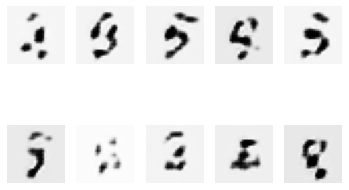

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.953125, 0.8984375, 0.00390625
1 / 100: 0.9453125, 1.0, 0.0
2 / 100: 0.9609375, 0.7109375, 0.0
3 / 100: 0.8828125, 0.96875, 0.0
4 / 100: 0.875, 0.9765625, 0.0
5 / 100: 0.921875, 0.8359375, 0.0
6 / 100: 0.75, 1.0, 0.0
7 / 100: 0.953125, 0.984375, 0.0
8 / 100: 0.96875, 0.828125, 0.0
9 / 100: 0.953125, 0.96875, 0.0
10 / 100: 0.9140625, 0.9375, 0.0
11 / 100: 0.96875, 0.625, 0.0
12 / 100: 0.9375, 1.0, 0.0
13 / 100: 0.9765625, 1.0, 0.0
14 / 100: 0.9921875, 0.8828125, 0.0
15 / 100: 0.9921875, 0.84375, 0.0
16 / 100: 0.9375, 0.9453125, 0.0
17 / 100: 0.890625, 0.734375, 0.00390625
18 / 100: 0.9375, 0.9765625, 0.0
19 / 100: 0.921875, 0.984375, 0.0
20 / 100: 0.984375, 0.6171875, 0.0
21 / 100: 0.890625, 1.0, 0.0
22 / 100: 0.890625, 0.9609375, 0.0
23 / 100: 0.9609375, 0.859375, 0.0
24 / 100: 0.9609375, 0.8671875, 0.0
25 / 100: 0.9453125, 0.96875, 0.0
26 / 100: 0.96875, 0.578125, 0.0
27 / 100: 0.9140625, 0.9453125, 0

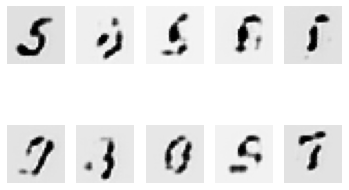

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9140625, 0.9296875, 0.0
1 / 100: 0.8984375, 0.765625, 0.0
2 / 100: 0.8984375, 0.8046875, 0.0
3 / 100: 0.921875, 0.71875, 0.0
4 / 100: 0.828125, 0.828125, 0.0
5 / 100: 0.84375, 0.8203125, 0.0
6 / 100: 0.8125, 1.0, 0.0
7 / 100: 0.9765625, 0.75, 0.0
8 / 100: 0.921875, 0.8828125, 0.0
9 / 100: 0.8984375, 0.984375, 0.0
10 / 100: 0.9765625, 0.5625, 0.0
11 / 100: 0.8671875, 1.0, 0.0
12 / 100: 0.8359375, 0.9765625, 0.0
13 / 100: 0.9453125, 0.7578125, 0.0
14 / 100: 0.8515625, 1.0, 0.0
15 / 100: 0.953125, 0.8203125, 0.0
16 / 100: 0.9921875, 0.671875, 0.0
17 / 100: 0.9296875, 1.0, 0.0
18 / 100: 0.9609375, 0.921875, 0.0
19 / 100: 0.9921875, 0.7890625, 0.0
20 / 100: 0.8359375, 0.9921875, 0.0
21 / 100: 0.9609375, 0.8515625, 0.0
22 / 100: 0.984375, 0.8203125, 0.0
23 / 100: 0.9140625, 0.9375, 0.0
24 / 100: 0.953125, 0.8984375, 0.0
25 / 100: 0.9765625, 0.8203125, 0.0
26 / 100: 0.875, 0.984375, 0.0
27 / 100: 0.96875, 0.

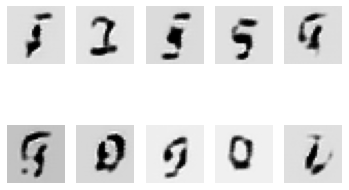

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.7578125, 0.921875, 0.0
1 / 100: 0.859375, 0.84375, 0.0
2 / 100: 0.75, 0.984375, 0.0
3 / 100: 0.9140625, 0.859375, 0.0
4 / 100: 0.84375, 1.0, 0.0
5 / 100: 0.8671875, 0.796875, 0.0
6 / 100: 0.921875, 0.9375, 0.0
7 / 100: 0.78125, 1.0, 0.0
8 / 100: 0.9453125, 0.890625, 0.0
9 / 100: 0.9140625, 0.875, 0.0
10 / 100: 0.8203125, 0.9296875, 0.0
11 / 100: 0.8125, 0.640625, 0.0078125
12 / 100: 0.921875, 0.8984375, 0.0
13 / 100: 0.8671875, 0.78125, 0.0
14 / 100: 0.609375, 0.9921875, 0.0
15 / 100: 0.921875, 0.90625, 0.0
16 / 100: 0.953125, 0.8515625, 0.0
17 / 100: 0.7578125, 0.953125, 0.0
18 / 100: 0.8828125, 0.859375, 0.00390625
19 / 100: 0.828125, 0.96875, 0.0
20 / 100: 0.9296875, 1.0, 0.0
21 / 100: 0.953125, 0.859375, 0.0
22 / 100: 0.8046875, 0.9921875, 0.0
23 / 100: 0.8203125, 0.859375, 0.0
24 / 100: 0.84375, 0.96875, 0.0
25 / 100: 0.9296875, 1.0, 0.0
26 / 100: 0.9921875, 0.59375, 0.0
27 / 100: 0.8515625, 1.0,

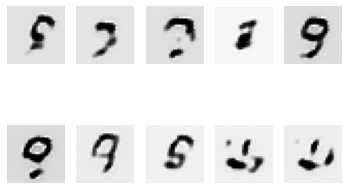

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9765625, 0.8515625, 0.0
1 / 100: 0.9609375, 0.7421875, 0.0
2 / 100: 0.8515625, 1.0, 0.0
3 / 100: 0.9921875, 0.8515625, 0.0
4 / 100: 0.9921875, 0.78125, 0.0
5 / 100: 0.7421875, 1.0, 0.0
6 / 100: 0.9921875, 0.71875, 0.0
7 / 100: 0.8984375, 0.8515625, 0.0
8 / 100: 0.7265625, 1.0, 0.0
9 / 100: 1.0, 0.734375, 0.0
10 / 100: 0.96875, 0.8046875, 0.0
11 / 100: 0.875, 0.96875, 0.0
12 / 100: 0.90625, 0.8828125, 0.0
13 / 100: 0.9296875, 0.859375, 0.0
14 / 100: 0.9140625, 0.984375, 0.0
15 / 100: 0.9296875, 0.8203125, 0.0
16 / 100: 0.9140625, 0.953125, 0.0
17 / 100: 0.8828125, 0.8984375, 0.0
18 / 100: 0.953125, 0.7578125, 0.0
19 / 100: 0.75, 0.96875, 0.0
20 / 100: 0.921875, 0.921875, 0.0
21 / 100: 1.0, 0.75, 0.0
22 / 100: 0.8203125, 0.75, 0.0
23 / 100: 0.828125, 0.8828125, 0.0
24 / 100: 0.828125, 0.90625, 0.0
25 / 100: 0.8671875, 1.0, 0.0
26 / 100: 0.984375, 0.7265625, 0.0
27 / 100: 0.921875, 0.9609375, 0.0
28 / 10

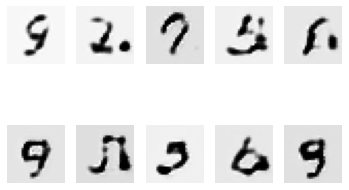

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8125, 0.9765625, 0.0
1 / 100: 0.8671875, 0.9140625, 0.0
2 / 100: 0.9140625, 1.0, 0.0
3 / 100: 1.0, 0.9765625, 0.0
4 / 100: 1.0, 0.5625, 0.0
5 / 100: 0.5703125, 1.0, 0.0
6 / 100: 0.96875, 0.6328125, 0.0
7 / 100: 0.9140625, 0.9921875, 0.0
8 / 100: 0.9140625, 0.9453125, 0.0
9 / 100: 0.9765625, 0.9765625, 0.0
10 / 100: 0.953125, 0.609375, 0.0
11 / 100: 0.734375, 0.9921875, 0.0
12 / 100: 0.953125, 0.53125, 0.00390625
13 / 100: 0.796875, 1.0, 0.0
14 / 100: 0.953125, 0.9765625, 0.0
15 / 100: 0.9765625, 0.78125, 0.0
16 / 100: 0.8828125, 0.8359375, 0.0
17 / 100: 0.890625, 0.703125, 0.00390625
18 / 100: 0.84375, 0.8203125, 0.0
19 / 100: 0.828125, 0.84375, 0.0
20 / 100: 0.8203125, 1.0, 0.0
21 / 100: 0.96875, 0.8359375, 0.0
22 / 100: 0.84375, 0.8828125, 0.0
23 / 100: 0.7421875, 0.9375, 0.0
24 / 100: 0.921875, 0.5390625, 0.0
25 / 100: 0.7265625, 0.921875, 0.0
26 / 100: 0.8046875, 0.7734375, 0.0
27 / 100: 0.8984375

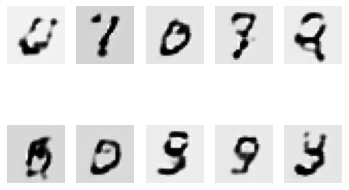

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.6328125, 1.0, 0.0
1 / 100: 0.9765625, 0.765625, 0.0
2 / 100: 0.90625, 0.6796875, 0.0
3 / 100: 0.609375, 1.0, 0.0
4 / 100: 0.9765625, 0.8671875, 0.0
5 / 100: 0.96875, 0.6484375, 0.0
6 / 100: 0.640625, 1.0, 0.0
7 / 100: 0.9765625, 0.9609375, 0.0
8 / 100: 0.96875, 0.9296875, 0.0
9 / 100: 0.921875, 0.9765625, 0.0
10 / 100: 0.9375, 0.8984375, 0.0
11 / 100: 0.90625, 0.4765625, 0.0
12 / 100: 0.484375, 1.0, 0.0
13 / 100: 0.8984375, 0.84375, 0.0
14 / 100: 0.90625, 0.625, 0.0
15 / 100: 0.640625, 1.0, 0.0
16 / 100: 0.953125, 0.7109375, 0.00390625
17 / 100: 0.8671875, 0.9296875, 0.0
18 / 100: 0.8671875, 1.0, 0.0
19 / 100: 0.9765625, 0.4140625, 0.0
20 / 100: 0.53125, 1.0, 0.0
21 / 100: 0.9921875, 0.7578125, 0.0
22 / 100: 0.953125, 0.9140625, 0.0
23 / 100: 0.6875, 0.9921875, 0.00390625
24 / 100: 0.9921875, 0.828125, 0.0
25 / 100: 0.9296875, 0.7734375, 0.0
26 / 100: 0.484375, 0.9609375, 0.0
27 / 100: 0.921875, 0.789

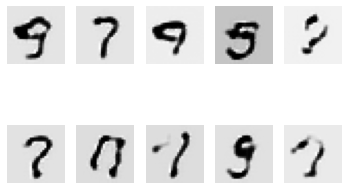

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.953125, 0.71875, 0.0
1 / 100: 0.78125, 0.9765625, 0.0
2 / 100: 0.9296875, 0.84375, 0.0
3 / 100: 0.9296875, 0.6015625, 0.0
4 / 100: 0.5546875, 0.96875, 0.0
5 / 100: 0.9140625, 0.828125, 0.0
6 / 100: 0.9140625, 0.6875, 0.0
7 / 100: 0.6171875, 1.0, 0.0
8 / 100: 0.9140625, 0.796875, 0.0
9 / 100: 0.9140625, 0.578125, 0.0
10 / 100: 0.4375, 0.9921875, 0.0
11 / 100: 0.9921875, 0.890625, 0.0
12 / 100: 0.90625, 0.84375, 0.0
13 / 100: 0.65625, 0.96875, 0.0
14 / 100: 0.9140625, 0.6328125, 0.0
15 / 100: 0.7421875, 0.6875, 0.0
16 / 100: 0.3984375, 0.90625, 0.0
17 / 100: 0.9296875, 0.9140625, 0.00390625
18 / 100: 0.875, 0.765625, 0.0
19 / 100: 0.703125, 0.8984375, 0.00390625
20 / 100: 0.828125, 0.671875, 0.0078125
21 / 100: 0.7578125, 0.78125, 0.00390625
22 / 100: 0.6328125, 0.984375, 0.0
23 / 100: 0.8671875, 0.5390625, 0.0
24 / 100: 0.75, 0.9765625, 0.0
25 / 100: 0.78125, 0.875, 0.0
26 / 100: 0.859375, 0.734375, 0.

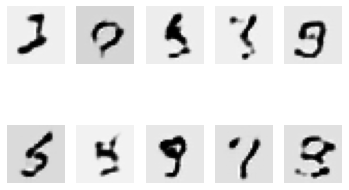

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9140625, 0.671875, 0.0
1 / 100: 0.7734375, 0.9765625, 0.00390625
2 / 100: 0.9140625, 0.40625, 0.0
3 / 100: 0.546875, 0.9140625, 0.0
4 / 100: 0.8515625, 0.8359375, 0.0
5 / 100: 0.8984375, 0.546875, 0.0
6 / 100: 0.6875, 0.9375, 0.0
7 / 100: 0.7890625, 0.984375, 0.00390625
8 / 100: 0.96875, 0.3984375, 0.0
9 / 100: 0.6015625, 1.0, 0.0
10 / 100: 1.0, 0.703125, 0.0
11 / 100: 0.9140625, 0.8671875, 0.0
12 / 100: 0.734375, 0.9609375, 0.0
13 / 100: 0.984375, 0.8828125, 0.0
14 / 100: 0.9375, 0.7890625, 0.0
15 / 100: 0.640625, 1.0, 0.0
16 / 100: 0.9296875, 0.4765625, 0.0
17 / 100: 0.7265625, 0.96875, 0.0
18 / 100: 0.828125, 0.828125, 0.0
19 / 100: 0.8125, 0.890625, 0.0
20 / 100: 0.9140625, 0.7265625, 0.0
21 / 100: 0.8046875, 0.9453125, 0.0
22 / 100: 0.90625, 0.5234375, 0.0
23 / 100: 0.6953125, 0.9921875, 0.0
24 / 100: 0.921875, 0.6875, 0.0
25 / 100: 0.8203125, 0.8671875, 0.0
26 / 100: 0.8828125, 0.96875, 0.0
27 /

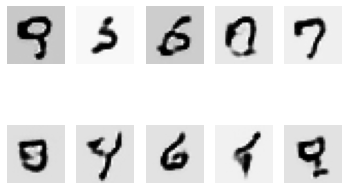

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.875, 0.6328125, 0.0
1 / 100: 0.5703125, 0.984375, 0.0
2 / 100: 0.859375, 0.953125, 0.0
3 / 100: 0.9609375, 0.7109375, 0.0
4 / 100: 0.7265625, 0.96875, 0.0
5 / 100: 0.9453125, 0.7421875, 0.0
6 / 100: 0.8203125, 0.671875, 0.0
7 / 100: 0.609375, 0.96875, 0.0
8 / 100: 0.8671875, 0.890625, 0.0
9 / 100: 0.921875, 0.609375, 0.0
10 / 100: 0.515625, 0.921875, 0.0
11 / 100: 0.84375, 0.890625, 0.0
12 / 100: 0.9296875, 0.578125, 0.0
13 / 100: 0.5703125, 0.8984375, 0.0
14 / 100: 0.8828125, 0.875, 0.0
15 / 100: 0.859375, 0.5390625, 0.00390625
16 / 100: 0.6875, 0.984375, 0.0
17 / 100: 0.8125, 0.5859375, 0.0
18 / 100: 0.7890625, 0.859375, 0.0
19 / 100: 0.640625, 0.9765625, 0.0
20 / 100: 0.90625, 0.84375, 0.0
21 / 100: 0.8515625, 0.96875, 0.0
22 / 100: 0.84375, 0.96875, 0.0
23 / 100: 0.96875, 0.7265625, 0.0
24 / 100: 0.6796875, 1.0, 0.0
25 / 100: 0.9296875, 0.8125, 0.0
26 / 100: 0.890625, 0.6328125, 0.0
27 / 100: 0.50

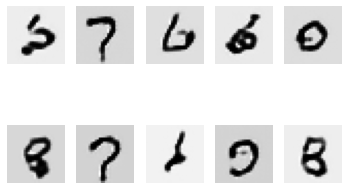

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.734375, 0.7109375, 0.0
1 / 100: 0.6796875, 0.890625, 0.0
2 / 100: 0.6640625, 0.5546875, 0.0078125
3 / 100: 0.5546875, 0.953125, 0.0
4 / 100: 0.8203125, 0.5625, 0.0
5 / 100: 0.671875, 0.75, 0.0
6 / 100: 0.65625, 0.796875, 0.0
7 / 100: 0.7734375, 0.8671875, 0.0
8 / 100: 0.8125, 0.6640625, 0.0
9 / 100: 0.640625, 0.984375, 0.0
10 / 100: 0.828125, 0.9453125, 0.0
11 / 100: 0.8984375, 0.4453125, 0.0
12 / 100: 0.5390625, 0.984375, 0.0
13 / 100: 0.8828125, 0.8671875, 0.0
14 / 100: 0.8671875, 0.59375, 0.0
15 / 100: 0.625, 0.96875, 0.0
16 / 100: 0.921875, 0.7421875, 0.0
17 / 100: 0.8671875, 0.546875, 0.0
18 / 100: 0.4453125, 0.921875, 0.00390625
19 / 100: 0.875, 0.890625, 0.0
20 / 100: 0.890625, 0.6328125, 0.0
21 / 100: 0.5859375, 0.96875, 0.0
22 / 100: 0.859375, 0.7421875, 0.0
23 / 100: 0.7578125, 0.953125, 0.0
24 / 100: 0.8671875, 0.890625, 0.0
25 / 100: 0.8046875, 0.640625, 0.0
26 / 100: 0.6484375, 0.984375, 

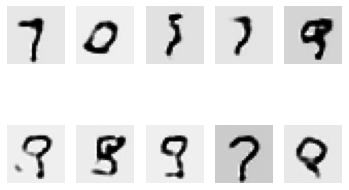

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.859375, 0.4296875, 0.0
1 / 100: 0.375, 1.0, 0.00390625
2 / 100: 0.9296875, 0.4296875, 0.0
3 / 100: 0.8359375, 0.7265625, 0.0
4 / 100: 0.5078125, 0.9375, 0.0
5 / 100: 0.90625, 0.8046875, 0.00390625
6 / 100: 0.828125, 0.8203125, 0.0
7 / 100: 0.625, 1.0, 0.0
8 / 100: 0.9453125, 0.421875, 0.0
9 / 100: 0.6796875, 0.984375, 0.0
10 / 100: 0.8203125, 0.8828125, 0.0
11 / 100: 0.828125, 0.8359375, 0.0
12 / 100: 0.7734375, 0.8359375, 0.0
13 / 100: 0.8046875, 0.9140625, 0.0
14 / 100: 0.78125, 0.453125, 0.0078125
15 / 100: 0.5, 0.9765625, 0.0
16 / 100: 0.8984375, 0.875, 0.0
17 / 100: 0.875, 0.5390625, 0.0
18 / 100: 0.5390625, 0.9765625, 0.0
19 / 100: 0.9765625, 0.59375, 0.0
20 / 100: 0.78125, 0.8125, 0.00390625
21 / 100: 0.515625, 0.9921875, 0.0
22 / 100: 0.953125, 0.625, 0.0
23 / 100: 0.765625, 0.7890625, 0.0
24 / 100: 0.671875, 0.9921875, 0.0
25 / 100: 0.9140625, 0.3671875, 0.0
26 / 100: 0.7578125, 0.9140625, 0.

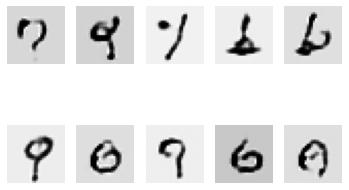

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.859375, 0.9375, 0.0
1 / 100: 0.78125, 0.984375, 0.0
2 / 100: 0.921875, 0.9921875, 0.0
3 / 100: 0.96875, 0.40625, 0.0
4 / 100: 0.5625, 1.0, 0.0
5 / 100: 0.96875, 0.28125, 0.0
6 / 100: 0.6640625, 1.0, 0.0
7 / 100: 0.875, 0.8359375, 0.0
8 / 100: 0.8515625, 0.984375, 0.0
9 / 100: 0.984375, 0.5234375, 0.0
10 / 100: 0.5703125, 1.0, 0.0
11 / 100: 1.0, 0.171875, 0.0
12 / 100: 0.578125, 1.0, 0.0
13 / 100: 0.9140625, 0.796875, 0.0
14 / 100: 0.953125, 0.5859375, 0.0
15 / 100: 0.59375, 1.0, 0.0
16 / 100: 0.9609375, 0.953125, 0.0
17 / 100: 0.9609375, 0.5703125, 0.0
18 / 100: 0.4296875, 1.0, 0.0
19 / 100: 0.9765625, 0.875, 0.0
20 / 100: 0.984375, 0.8828125, 0.0
21 / 100: 0.7890625, 0.9140625, 0.0
22 / 100: 0.875, 0.6015625, 0.0
23 / 100: 0.7109375, 1.0, 0.0
24 / 100: 0.96875, 0.3515625, 0.0
25 / 100: 0.703125, 1.0, 0.0
26 / 100: 0.9765625, 0.9765625, 0.0
27 / 100: 1.0, 0.96875, 0.0
28 / 100: 0.875, 1.0, 0.0
29 / 10

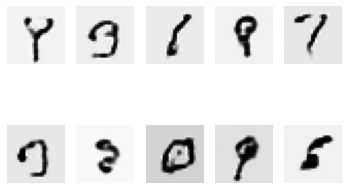

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.859375, 0.578125, 0.0
1 / 100: 0.5, 0.953125, 0.0
2 / 100: 0.828125, 0.984375, 0.0
3 / 100: 0.96875, 0.734375, 0.0
4 / 100: 0.7421875, 0.984375, 0.0
5 / 100: 0.921875, 0.7890625, 0.0
6 / 100: 0.6796875, 0.421875, 0.0078125
7 / 100: 0.5390625, 0.8984375, 0.0
8 / 100: 0.7109375, 1.0, 0.0
9 / 100: 0.9609375, 0.578125, 0.0
10 / 100: 0.734375, 1.0, 0.0
11 / 100: 0.828125, 0.8046875, 0.0078125
12 / 100: 0.875, 0.3984375, 0.00390625
13 / 100: 0.4296875, 1.0, 0.0
14 / 100: 0.9140625, 0.9140625, 0.0
15 / 100: 0.9609375, 0.8046875, 0.0
16 / 100: 0.7109375, 0.96875, 0.0
17 / 100: 0.890625, 0.6484375, 0.0
18 / 100: 0.875, 0.609375, 0.0
19 / 100: 0.3671875, 0.984375, 0.0
20 / 100: 0.890625, 0.984375, 0.0
21 / 100: 0.9921875, 0.8125, 0.0
22 / 100: 0.7421875, 0.9453125, 0.0
23 / 100: 0.9296875, 0.609375, 0.0
24 / 100: 0.7109375, 0.4296875, 0.0
25 / 100: 0.453125, 0.90625, 0.0
26 / 100: 0.78125, 0.96875, 0.0
27 / 100

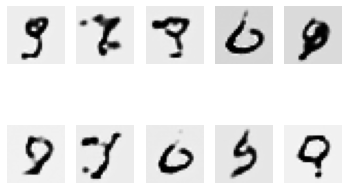

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5390625, 1.0, 0.0
1 / 100: 0.9453125, 0.921875, 0.0
2 / 100: 0.96875, 0.6015625, 0.0
3 / 100: 0.609375, 1.0, 0.0
4 / 100: 0.9453125, 0.875, 0.0
5 / 100: 0.9453125, 0.6171875, 0.0
6 / 100: 0.4453125, 1.0, 0.0
7 / 100: 0.9921875, 0.9921875, 0.0
8 / 100: 1.0, 0.9609375, 0.0
9 / 100: 0.8359375, 0.796875, 0.0
10 / 100: 0.8203125, 0.7578125, 0.0
11 / 100: 0.7421875, 1.0, 0.0
12 / 100: 0.9609375, 0.2265625, 0.0
13 / 100: 0.5, 1.0, 0.0
14 / 100: 0.921875, 0.7890625, 0.00390625
15 / 100: 0.8515625, 0.859375, 0.0
16 / 100: 0.6953125, 1.0, 0.0
17 / 100: 0.9140625, 0.8984375, 0.0
18 / 100: 0.9375, 0.875, 0.0
19 / 100: 0.7578125, 0.9921875, 0.0
20 / 100: 0.90625, 0.5078125, 0.0
21 / 100: 0.703125, 0.9453125, 0.0
22 / 100: 0.875, 0.8515625, 0.0
23 / 100: 0.84375, 0.5234375, 0.0
24 / 100: 0.5, 0.984375, 0.00390625
25 / 100: 0.921875, 0.7109375, 0.0
26 / 100: 0.890625, 0.6640625, 0.0
27 / 100: 0.5, 1.0, 0.0
28 / 100:

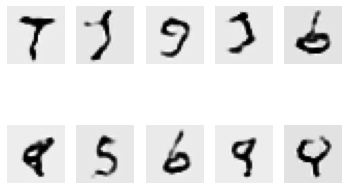

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.6953125, 1.0, 0.0
1 / 100: 0.875, 0.7890625, 0.0
2 / 100: 0.8515625, 0.4765625, 0.0
3 / 100: 0.4375, 1.0, 0.0
4 / 100: 0.953125, 0.6953125, 0.0
5 / 100: 0.8828125, 0.625, 0.0
6 / 100: 0.5546875, 1.0, 0.0
7 / 100: 0.953125, 0.8515625, 0.0
8 / 100: 0.9453125, 0.5078125, 0.0
9 / 100: 0.4609375, 1.0, 0.0
10 / 100: 0.984375, 0.9921875, 0.0
11 / 100: 0.984375, 0.4375, 0.0
12 / 100: 0.4921875, 1.0, 0.0
13 / 100: 0.9921875, 0.9921875, 0.0
14 / 100: 1.0, 0.96875, 0.0
15 / 100: 0.953125, 1.0, 0.0
16 / 100: 0.9921875, 0.9921875, 0.0
17 / 100: 1.0, 1.0, 0.0
18 / 100: 1.0, 0.9765625, 0.00390625
19 / 100: 1.0, 1.0, 0.0
20 / 100: 0.9921875, 1.0, 0.0
21 / 100: 1.0, 1.0, 0.0
22 / 100: 1.0, 0.8828125, 0.0
23 / 100: 0.75, 0.9609375, 0.00390625
24 / 100: 0.9296875, 0.75, 0.0
25 / 100: 0.7890625, 0.859375, 0.0
26 / 100: 0.765625, 0.9921875, 0.0
27 / 100: 0.953125, 0.3828125, 0.0
28 / 100: 0.5859375, 1.0, 0.0
29 / 100: 0.9

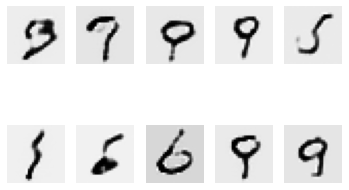

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9375, 0.8515625, 0.0
1 / 100: 0.9296875, 0.71875, 0.0
2 / 100: 0.5, 0.9921875, 0.0
3 / 100: 0.9296875, 0.671875, 0.0
4 / 100: 0.78125, 0.9140625, 0.0
5 / 100: 0.7734375, 0.984375, 0.0
6 / 100: 0.9296875, 1.0, 0.0
7 / 100: 0.953125, 0.3828125, 0.0
8 / 100: 0.4609375, 1.0, 0.0
9 / 100: 1.0, 0.25, 0.0
10 / 100: 0.65625, 1.0, 0.0
11 / 100: 0.8828125, 0.7421875, 0.00390625
12 / 100: 0.859375, 0.75, 0.0
13 / 100: 0.65625, 1.0, 0.0
14 / 100: 0.8984375, 0.9296875, 0.0
15 / 100: 0.9375, 0.5078125, 0.0
16 / 100: 0.5234375, 1.0, 0.0
17 / 100: 0.9609375, 0.796875, 0.0
18 / 100: 0.984375, 0.671875, 0.0
19 / 100: 0.4453125, 1.0, 0.0
20 / 100: 1.0, 0.8828125, 0.0
21 / 100: 0.984375, 0.609375, 0.0
22 / 100: 0.515625, 1.0, 0.0
23 / 100: 0.96875, 0.9375, 0.00390625
24 / 100: 0.9921875, 0.59375, 0.0
25 / 100: 0.6640625, 1.0, 0.0
26 / 100: 0.875, 0.921875, 0.0
27 / 100: 0.984375, 0.3671875, 0.0
28 / 100: 0.46875, 1.0, 0.

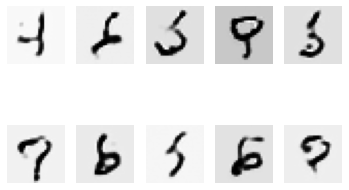

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5625, 1.0, 0.0
1 / 100: 0.8515625, 0.6328125, 0.0
2 / 100: 0.828125, 0.78125, 0.0
3 / 100: 0.53125, 0.953125, 0.0
4 / 100: 0.9296875, 0.578125, 0.0
5 / 100: 0.609375, 0.8984375, 0.0
6 / 100: 0.8515625, 0.84375, 0.0
7 / 100: 0.7734375, 0.6171875, 0.0
8 / 100: 0.640625, 0.9765625, 0.0
9 / 100: 0.7890625, 0.8203125, 0.0
10 / 100: 0.7265625, 0.4921875, 0.00390625
11 / 100: 0.5859375, 0.96875, 0.00390625
12 / 100: 0.828125, 0.8515625, 0.0
13 / 100: 0.8203125, 0.4921875, 0.0
14 / 100: 0.515625, 0.9921875, 0.00390625
15 / 100: 0.9140625, 0.421875, 0.0
16 / 100: 0.6484375, 0.53125, 0.0
17 / 100: 0.40625, 0.9453125, 0.0
18 / 100: 0.90625, 0.5703125, 0.0
19 / 100: 0.6640625, 0.671875, 0.0
20 / 100: 0.5234375, 0.984375, 0.0
21 / 100: 0.8671875, 0.6875, 0.0
22 / 100: 0.7109375, 0.7734375, 0.0
23 / 100: 0.609375, 0.7421875, 0.0
24 / 100: 0.6484375, 0.4609375, 0.0
25 / 100: 0.5625, 0.734375, 0.00390625
26 / 100: 0.

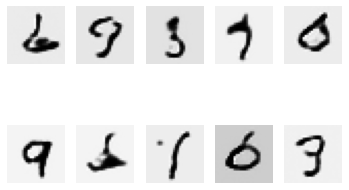

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.875, 0.3671875, 0.0
1 / 100: 0.3125, 0.9921875, 0.00390625
2 / 100: 0.84375, 0.6484375, 0.0
3 / 100: 0.890625, 0.7109375, 0.0
4 / 100: 0.5078125, 1.0, 0.0
5 / 100: 0.8828125, 0.515625, 0.0
6 / 100: 0.78125, 0.6328125, 0.0
7 / 100: 0.4296875, 0.9375, 0.0
8 / 100: 0.9140625, 0.6875, 0.00390625
9 / 100: 0.7421875, 0.6953125, 0.0
10 / 100: 0.5859375, 0.9609375, 0.0
11 / 100: 0.8515625, 0.84375, 0.0
12 / 100: 0.8203125, 0.6171875, 0.00390625
13 / 100: 0.5, 0.90625, 0.0
14 / 100: 0.8125, 0.7578125, 0.0
15 / 100: 0.8359375, 0.6640625, 0.0
16 / 100: 0.421875, 0.953125, 0.0
17 / 100: 0.890625, 0.421875, 0.00390625
18 / 100: 0.671875, 0.921875, 0.0
19 / 100: 0.703125, 0.6328125, 0.0
20 / 100: 0.703125, 0.9765625, 0.0
21 / 100: 0.7578125, 0.4296875, 0.0
22 / 100: 0.65625, 0.7734375, 0.0
23 / 100: 0.5703125, 0.9453125, 0.0
24 / 100: 0.9453125, 0.359375, 0.0
25 / 100: 0.53125, 0.984375, 0.0
26 / 100: 0.84375, 0.88

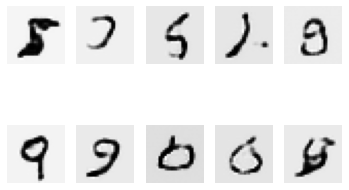

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8828125, 0.6015625, 0.0
1 / 100: 0.75, 0.484375, 0.0
2 / 100: 0.4609375, 0.8515625, 0.01171875
3 / 100: 0.859375, 0.65625, 0.0
4 / 100: 0.6484375, 0.4765625, 0.0
5 / 100: 0.5078125, 1.0, 0.0
6 / 100: 0.9375, 0.5390625, 0.0
7 / 100: 0.7265625, 0.953125, 0.0
8 / 100: 0.703125, 0.9296875, 0.0
9 / 100: 0.9375, 0.5078125, 0.0
10 / 100: 0.5, 1.0, 0.0
11 / 100: 0.9296875, 0.8203125, 0.0
12 / 100: 0.8828125, 0.6328125, 0.0
13 / 100: 0.4375, 1.0, 0.0
14 / 100: 0.9609375, 0.5859375, 0.0
15 / 100: 0.7421875, 0.7578125, 0.00390625
16 / 100: 0.625, 0.9921875, 0.0
17 / 100: 0.890625, 0.71875, 0.0
18 / 100: 0.71875, 0.75, 0.0
19 / 100: 0.71875, 0.9375, 0.00390625
20 / 100: 0.7265625, 0.6015625, 0.0
21 / 100: 0.84375, 0.75, 0.0
22 / 100: 0.59375, 0.9453125, 0.0
23 / 100: 0.8671875, 0.5703125, 0.0
24 / 100: 0.734375, 0.75, 0.00390625
25 / 100: 0.7421875, 0.796875, 0.0
26 / 100: 0.71875, 0.734375, 0.00390625
27 / 100: 

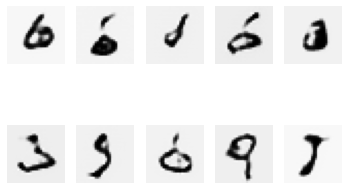

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.75, 0.9375, 0.0
1 / 100: 0.9609375, 0.4453125, 0.0
2 / 100: 0.4375, 1.0, 0.0
3 / 100: 0.9609375, 0.65625, 0.0
4 / 100: 0.875, 0.6875, 0.0
5 / 100: 0.5234375, 0.953125, 0.0
6 / 100: 0.9140625, 0.59375, 0.0
7 / 100: 0.7890625, 0.8046875, 0.0
8 / 100: 0.5703125, 0.9453125, 0.0
9 / 100: 0.875, 0.5703125, 0.0
10 / 100: 0.609375, 0.953125, 0.0
11 / 100: 0.890625, 0.9609375, 0.0
12 / 100: 0.8828125, 0.6484375, 0.00390625
13 / 100: 0.5546875, 0.9921875, 0.0
14 / 100: 0.9609375, 0.859375, 0.0
15 / 100: 0.859375, 0.46875, 0.0
16 / 100: 0.4453125, 1.0, 0.0
17 / 100: 0.96875, 0.734375, 0.0
18 / 100: 0.84375, 0.625, 0.0
19 / 100: 0.5625, 1.0, 0.0
20 / 100: 0.9296875, 0.8125, 0.0
21 / 100: 0.875, 0.640625, 0.0
22 / 100: 0.40625, 1.0, 0.0
23 / 100: 0.9375, 0.9375, 0.00390625
24 / 100: 0.984375, 0.421875, 0.0
25 / 100: 0.375, 1.0, 0.0
26 / 100: 0.984375, 0.734375, 0.00390625
27 / 100: 0.953125, 0.7421875, 0.0
28 / 10

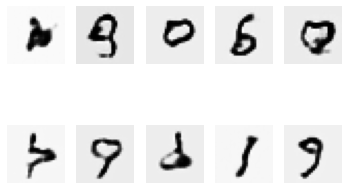

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.625, 0.96875, 0.0
1 / 100: 0.921875, 0.296875, 0.0
2 / 100: 0.4453125, 0.6171875, 0.00390625
3 / 100: 0.5703125, 0.6953125, 0.0
4 / 100: 0.703125, 0.9375, 0.0
5 / 100: 0.875, 0.53125, 0.0
6 / 100: 0.5859375, 0.9609375, 0.0
7 / 100: 0.875, 0.53125, 0.0
8 / 100: 0.6640625, 0.8828125, 0.00390625
9 / 100: 0.6875, 0.5859375, 0.00390625
10 / 100: 0.8203125, 0.59375, 0.00390625
11 / 100: 0.546875, 0.6875, 0.0
12 / 100: 0.6171875, 0.8125, 0.00390625
13 / 100: 0.59375, 0.65625, 0.00390625
14 / 100: 0.6328125, 0.9140625, 0.0
15 / 100: 0.8515625, 0.59375, 0.0
16 / 100: 0.5703125, 0.96875, 0.0
17 / 100: 0.9296875, 0.78125, 0.0
18 / 100: 0.796875, 0.6171875, 0.0
19 / 100: 0.3515625, 0.921875, 0.0078125
20 / 100: 0.9765625, 0.21875, 0.00390625
21 / 100: 0.3984375, 0.734375, 0.0
22 / 100: 0.6171875, 0.8671875, 0.0
23 / 100: 0.8046875, 0.671875, 0.0
24 / 100: 0.5859375, 0.75, 0.0
25 / 100: 0.6328125, 0.7265625, 0.0
2

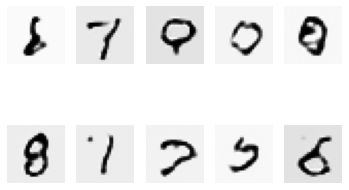

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8828125, 0.59375, 0.0
1 / 100: 0.4453125, 1.0, 0.0
2 / 100: 0.96875, 0.5390625, 0.0
3 / 100: 0.7109375, 0.7890625, 0.0
4 / 100: 0.578125, 0.9765625, 0.0
5 / 100: 0.96875, 0.5390625, 0.0
6 / 100: 0.703125, 0.6796875, 0.0
7 / 100: 0.53125, 0.96875, 0.0
8 / 100: 0.890625, 0.7578125, 0.00390625
9 / 100: 0.8203125, 0.7734375, 0.0
10 / 100: 0.6484375, 0.984375, 0.0
11 / 100: 0.96875, 0.3359375, 0.0
12 / 100: 0.671875, 0.875, 0.00390625
13 / 100: 0.5703125, 0.9296875, 0.0
14 / 100: 0.828125, 0.546875, 0.0
15 / 100: 0.734375, 0.9375, 0.0
16 / 100: 0.6171875, 0.9921875, 0.0
17 / 100: 0.953125, 0.453125, 0.0
18 / 100: 0.5546875, 0.8984375, 0.00390625
19 / 100: 0.8515625, 0.890625, 0.0
20 / 100: 0.875, 0.625, 0.0078125
21 / 100: 0.609375, 0.984375, 0.00390625
22 / 100: 0.890625, 0.9140625, 0.0
23 / 100: 0.8125, 0.421875, 0.0
24 / 100: 0.625, 1.0, 0.0
25 / 100: 0.9296875, 0.5859375, 0.0
26 / 100: 0.75, 0.5390625,

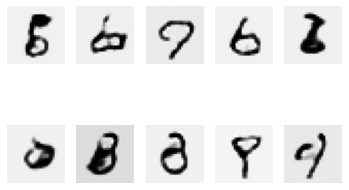

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9375, 0.7421875, 0.00390625
1 / 100: 0.9296875, 0.6796875, 0.0
2 / 100: 0.34375, 1.0, 0.0
3 / 100: 0.9609375, 0.5078125, 0.00390625
4 / 100: 0.7265625, 0.6015625, 0.0
5 / 100: 0.40625, 0.8984375, 0.00390625
6 / 100: 0.84375, 0.7109375, 0.0
7 / 100: 0.8671875, 0.6796875, 0.0
8 / 100: 0.3125, 0.9765625, 0.0
9 / 100: 0.8984375, 0.671875, 0.0
10 / 100: 0.8046875, 0.515625, 0.0
11 / 100: 0.40625, 1.0, 0.0
12 / 100: 0.9453125, 0.4453125, 0.0
13 / 100: 0.703125, 0.6328125, 0.00390625
14 / 100: 0.53125, 0.8984375, 0.0
15 / 100: 0.7734375, 0.9140625, 0.0
16 / 100: 0.8046875, 0.4375, 0.0
17 / 100: 0.515625, 0.9921875, 0.0
18 / 100: 0.921875, 0.890625, 0.0
19 / 100: 0.8984375, 0.6875, 0.0
20 / 100: 0.46875, 0.9921875, 0.00390625
21 / 100: 0.953125, 0.46875, 0.0
22 / 100: 0.671875, 0.484375, 0.0
23 / 100: 0.4375, 0.9765625, 0.00390625
24 / 100: 0.8671875, 0.984375, 0.0
25 / 100: 0.9765625, 0.4921875, 0.0
26 / 100

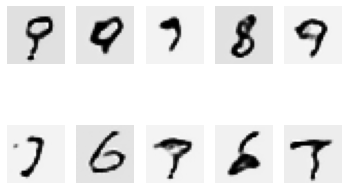

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.65625, 0.953125, 0.0
1 / 100: 0.703125, 0.5703125, 0.0
2 / 100: 0.8125, 0.6875, 0.0
3 / 100: 0.5, 0.96875, 0.0
4 / 100: 0.8359375, 0.46875, 0.00390625
5 / 100: 0.796875, 0.8515625, 0.0
6 / 100: 0.5390625, 0.8203125, 0.00390625
7 / 100: 0.7109375, 0.4453125, 0.00390625
8 / 100: 0.640625, 0.8671875, 0.00390625
9 / 100: 0.578125, 0.46875, 0.00390625
10 / 100: 0.65625, 0.9140625, 0.0
11 / 100: 0.5859375, 0.78125, 0.00390625
12 / 100: 0.65625, 0.71875, 0.01171875
13 / 100: 0.75, 0.484375, 0.0
14 / 100: 0.3515625, 0.9296875, 0.00390625
15 / 100: 0.8984375, 0.3984375, 0.0
16 / 100: 0.5078125, 0.9140625, 0.00390625
17 / 100: 0.6953125, 0.796875, 0.0
18 / 100: 0.75, 0.6796875, 0.0
19 / 100: 0.5390625, 0.8125, 0.0
20 / 100: 0.75, 0.7734375, 0.00390625
21 / 100: 0.7734375, 0.59375, 0.00390625
22 / 100: 0.453125, 0.984375, 0.0
23 / 100: 0.921875, 0.7578125, 0.0
24 / 100: 0.8984375, 0.4921875, 0.00390625
25 / 100:

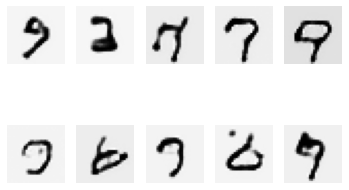

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.75, 0.00390625
1 / 100: 0.90625, 0.9765625, 0.0
2 / 100: 0.8828125, 0.9921875, 0.0078125
3 / 100: 0.9453125, 0.6953125, 0.0
4 / 100: 0.828125, 1.0, 0.0
5 / 100: 0.9453125, 0.5859375, 0.0
6 / 100: 0.6796875, 0.8984375, 0.0
7 / 100: 0.8203125, 0.9921875, 0.0
8 / 100: 0.9453125, 0.546875, 0.0
9 / 100: 0.734375, 0.984375, 0.0
10 / 100: 0.859375, 0.890625, 0.0
11 / 100: 0.90625, 0.390625, 0.0
12 / 100: 0.4609375, 1.0, 0.0
13 / 100: 0.9296875, 0.8984375, 0.0
14 / 100: 0.8828125, 0.5, 0.0
15 / 100: 0.3203125, 0.9921875, 0.00390625
16 / 100: 0.9453125, 0.703125, 0.0078125
17 / 100: 0.8828125, 0.984375, 0.0
18 / 100: 0.890625, 1.0, 0.0
19 / 100: 1.0, 1.0, 0.0
20 / 100: 1.0, 0.8828125, 0.0
21 / 100: 1.0, 1.0, 0.0
22 / 100: 1.0, 1.0, 0.0
23 / 100: 1.0, 0.875, 0.0
24 / 100: 0.921875, 1.0, 0.0
25 / 100: 0.984375, 0.9375, 0.0
26 / 100: 1.0, 1.0, 0.0
27 / 100: 0.9765625, 0.7890625, 0.0
28 / 100: 0.7734375, 0.92

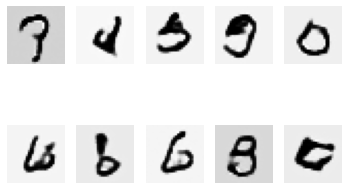

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.328125, 1.0, 0.0
1 / 100: 0.9765625, 0.875, 0.0
2 / 100: 0.984375, 0.859375, 0.0
3 / 100: 0.640625, 0.984375, 0.0
4 / 100: 0.96875, 0.78125, 0.00390625
5 / 100: 0.9140625, 0.5390625, 0.0
6 / 100: 0.28125, 0.9921875, 0.0
7 / 100: 0.921875, 0.9765625, 0.0
8 / 100: 0.984375, 0.46875, 0.0
9 / 100: 0.6640625, 1.0, 0.0
10 / 100: 0.9375, 0.765625, 0.0
11 / 100: 0.984375, 0.5625, 0.0
12 / 100: 0.3203125, 0.984375, 0.0
13 / 100: 0.9765625, 0.640625, 0.0
14 / 100: 0.796875, 0.4765625, 0.0
15 / 100: 0.3671875, 0.984375, 0.0
16 / 100: 0.9453125, 0.46875, 0.0
17 / 100: 0.78125, 0.7421875, 0.00390625
18 / 100: 0.390625, 0.9765625, 0.0
19 / 100: 0.9296875, 0.53125, 0.0
20 / 100: 0.703125, 0.5859375, 0.00390625
21 / 100: 0.4140625, 0.90625, 0.0078125
22 / 100: 0.859375, 0.8359375, 0.0
23 / 100: 0.7890625, 0.3515625, 0.00390625
24 / 100: 0.359375, 0.984375, 0.00390625
25 / 100: 0.8359375, 0.7109375, 0.0
26 / 100: 0.83

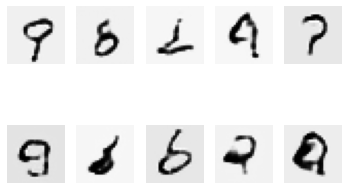

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.75, 0.4921875, 0.00390625
1 / 100: 0.4921875, 0.9765625, 0.0
2 / 100: 0.96875, 0.1640625, 0.0
3 / 100: 0.3046875, 1.0, 0.0
4 / 100: 0.859375, 0.65625, 0.0
5 / 100: 0.9140625, 0.7109375, 0.0
6 / 100: 0.3359375, 0.9453125, 0.0
7 / 100: 0.953125, 0.859375, 0.0
8 / 100: 0.796875, 0.4765625, 0.0078125
9 / 100: 0.5078125, 0.8515625, 0.0
10 / 100: 0.8359375, 0.9453125, 0.0
11 / 100: 0.859375, 0.3984375, 0.00390625
12 / 100: 0.59375, 1.0, 0.0
13 / 100: 0.8671875, 0.6953125, 0.0
14 / 100: 0.78125, 0.5625, 0.00390625
15 / 100: 0.5, 0.8359375, 0.0
16 / 100: 0.8125, 0.8984375, 0.00390625
17 / 100: 0.9453125, 0.578125, 0.0
18 / 100: 0.5546875, 1.0, 0.0
19 / 100: 0.9609375, 0.6796875, 0.0
20 / 100: 0.859375, 0.8984375, 0.0
21 / 100: 0.8046875, 0.984375, 0.0
22 / 100: 0.859375, 0.828125, 0.00390625
23 / 100: 0.9453125, 0.6171875, 0.0
24 / 100: 0.4375, 1.0, 0.0
25 / 100: 0.9765625, 0.46875, 0.0
26 / 100: 0.6875, 0.92

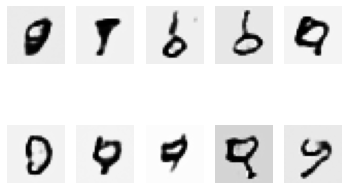

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.40625, 1.0, 0.0
1 / 100: 0.953125, 0.890625, 0.00390625
2 / 100: 0.921875, 0.5625, 0.0
3 / 100: 0.3984375, 0.9921875, 0.0
4 / 100: 0.9609375, 0.5546875, 0.0
5 / 100: 0.734375, 0.453125, 0.0
6 / 100: 0.3515625, 0.984375, 0.0
7 / 100: 0.96875, 0.625, 0.00390625
8 / 100: 0.796875, 0.7265625, 0.0
9 / 100: 0.375, 0.9453125, 0.0
10 / 100: 0.9140625, 0.8359375, 0.0
11 / 100: 0.9453125, 0.5234375, 0.0
12 / 100: 0.4296875, 1.0, 0.0
13 / 100: 0.9609375, 0.5625, 0.00390625
14 / 100: 0.90625, 0.6328125, 0.0
15 / 100: 0.359375, 0.9921875, 0.0
16 / 100: 0.9921875, 0.5234375, 0.0
17 / 100: 0.6640625, 0.453125, 0.00390625
18 / 100: 0.3671875, 0.984375, 0.0
19 / 100: 0.9296875, 0.7578125, 0.0
20 / 100: 0.890625, 0.5546875, 0.0
21 / 100: 0.40625, 1.0, 0.0
22 / 100: 0.953125, 0.5625, 0.0
23 / 100: 0.78125, 0.5859375, 0.0
24 / 100: 0.4296875, 0.9609375, 0.0
25 / 100: 0.9453125, 0.84375, 0.0
26 / 100: 0.890625, 0.640625, 

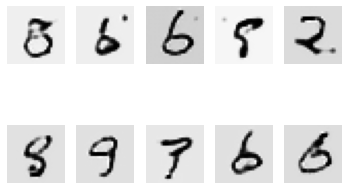

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.7578125, 0.8359375, 0.0
1 / 100: 0.703125, 0.46875, 0.0
2 / 100: 0.6640625, 0.9921875, 0.0
3 / 100: 0.9296875, 0.4140625, 0.0
4 / 100: 0.5703125, 0.4375, 0.0078125
5 / 100: 0.46875, 0.7109375, 0.00390625
6 / 100: 0.734375, 0.9765625, 0.0
7 / 100: 0.8671875, 0.3046875, 0.0
8 / 100: 0.484375, 1.0, 0.0
9 / 100: 0.84375, 0.3671875, 0.00390625
10 / 100: 0.7265625, 0.6875, 0.0
11 / 100: 0.421875, 0.8671875, 0.0
12 / 100: 0.859375, 0.78125, 0.0
13 / 100: 0.6328125, 0.3671875, 0.00390625
14 / 100: 0.3671875, 0.953125, 0.0
15 / 100: 0.8828125, 0.734375, 0.0
16 / 100: 0.7890625, 0.6640625, 0.0
17 / 100: 0.5390625, 1.0, 0.0
18 / 100: 0.9453125, 0.3671875, 0.0
19 / 100: 0.484375, 0.9609375, 0.0
20 / 100: 0.8515625, 0.8046875, 0.0
21 / 100: 0.8671875, 0.5234375, 0.0
22 / 100: 0.328125, 1.0, 0.0
23 / 100: 0.9921875, 0.8359375, 0.0
24 / 100: 0.953125, 0.625, 0.0
25 / 100: 0.3359375, 1.0, 0.0
26 / 100: 0.9921875, 0.2

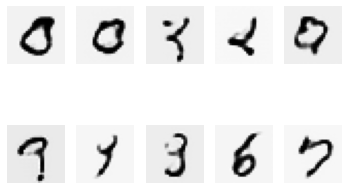

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9765625, 0.7265625, 0.0
1 / 100: 0.9140625, 0.8203125, 0.0
2 / 100: 0.578125, 1.0, 0.0
3 / 100: 0.9765625, 0.9765625, 0.00390625
4 / 100: 0.9921875, 0.6875, 0.0
5 / 100: 0.6640625, 1.0, 0.0
6 / 100: 1.0, 1.0, 0.0
7 / 100: 1.0, 0.7265625, 0.00390625
8 / 100: 0.96875, 1.0, 0.0
9 / 100: 0.953125, 1.0, 0.0
10 / 100: 0.9921875, 0.8125, 0.0
11 / 100: 0.890625, 0.9921875, 0.0
12 / 100: 0.9453125, 0.9453125, 0.0
13 / 100: 0.90625, 0.640625, 0.0
14 / 100: 0.515625, 0.9921875, 0.0
15 / 100: 0.9765625, 0.78125, 0.0
16 / 100: 0.9140625, 0.5703125, 0.0
17 / 100: 0.484375, 1.0, 0.00390625
18 / 100: 0.96875, 0.53125, 0.0
19 / 100: 0.8046875, 0.6171875, 0.0
20 / 100: 0.3828125, 0.8828125, 0.00390625
21 / 100: 0.9609375, 0.5234375, 0.0
22 / 100: 0.6484375, 0.7578125, 0.0
23 / 100: 0.515625, 0.859375, 0.0
24 / 100: 0.8046875, 0.4921875, 0.0
25 / 100: 0.484375, 0.7578125, 0.00390625
26 / 100: 0.6484375, 0.984375, 0.0
27

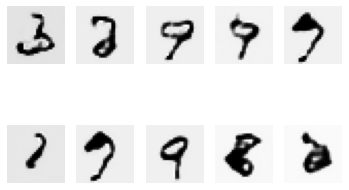

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.984375, 0.796875, 0.0
1 / 100: 0.9140625, 0.6484375, 0.0
2 / 100: 0.578125, 0.9921875, 0.00390625
3 / 100: 0.8984375, 0.9375, 0.0
4 / 100: 0.9609375, 0.703125, 0.0
5 / 100: 0.421875, 1.0, 0.0
6 / 100: 1.0, 0.328125, 0.0
7 / 100: 0.65625, 1.0, 0.0
8 / 100: 0.7734375, 0.3515625, 0.00390625
9 / 100: 0.8203125, 0.6953125, 0.0
10 / 100: 0.328125, 0.640625, 0.00390625
11 / 100: 0.71875, 0.765625, 0.0
12 / 100: 0.703125, 0.5078125, 0.0
13 / 100: 0.40625, 0.96875, 0.0
14 / 100: 0.8828125, 0.1875, 0.0
15 / 100: 0.296875, 0.9296875, 0.0
16 / 100: 0.859375, 0.5546875, 0.01171875
17 / 100: 0.671875, 0.8203125, 0.0
18 / 100: 0.4765625, 0.8671875, 0.00390625
19 / 100: 0.796875, 0.390625, 0.0
20 / 100: 0.3671875, 0.84375, 0.0
21 / 100: 0.8203125, 0.359375, 0.0
22 / 100: 0.4453125, 0.9453125, 0.0
23 / 100: 0.671875, 0.7890625, 0.0
24 / 100: 0.7109375, 0.421875, 0.0
25 / 100: 0.546875, 0.9375, 0.0
26 / 100: 0.796875, 

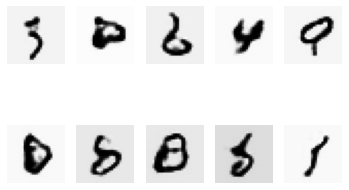

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9375, 0.859375, 0.00390625
1 / 100: 0.984375, 0.84375, 0.0
2 / 100: 0.6796875, 0.9921875, 0.0
3 / 100: 0.953125, 1.0, 0.0
4 / 100: 1.0, 0.5703125, 0.0
5 / 100: 0.6796875, 1.0, 0.0
6 / 100: 1.0, 0.421875, 0.0
7 / 100: 0.796875, 0.6953125, 0.00390625
8 / 100: 0.34375, 0.8984375, 0.0
9 / 100: 0.9296875, 0.6328125, 0.00390625
10 / 100: 0.6953125, 0.375, 0.0
11 / 100: 0.4921875, 0.984375, 0.0
12 / 100: 0.8515625, 0.46875, 0.00390625
13 / 100: 0.671875, 0.6171875, 0.0
14 / 100: 0.4453125, 0.9453125, 0.0
15 / 100: 0.7890625, 0.8515625, 0.0
16 / 100: 0.8515625, 0.53125, 0.0
17 / 100: 0.5390625, 1.0, 0.0
18 / 100: 0.96875, 0.4296875, 0.0
19 / 100: 0.71875, 0.8046875, 0.0
20 / 100: 0.6953125, 0.9765625, 0.0
21 / 100: 0.84375, 0.6484375, 0.0
22 / 100: 0.75, 0.7734375, 0.0
23 / 100: 0.6015625, 0.9921875, 0.00390625
24 / 100: 0.984375, 0.4921875, 0.0
25 / 100: 0.5078125, 0.9296875, 0.00390625
26 / 100: 0.84375, 0.

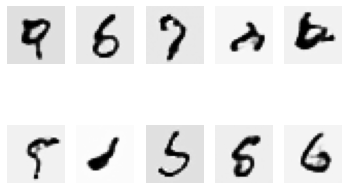

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.3984375, 0.9765625, 0.00390625
1 / 100: 0.9140625, 0.4296875, 0.00390625
2 / 100: 0.703125, 0.515625, 0.0
3 / 100: 0.2421875, 0.9375, 0.01171875
4 / 100: 0.953125, 0.7890625, 0.0
5 / 100: 0.8671875, 0.703125, 0.0
6 / 100: 0.4609375, 1.0, 0.0078125
7 / 100: 0.9765625, 0.3203125, 0.00390625
8 / 100: 0.6171875, 0.953125, 0.0
9 / 100: 0.7734375, 0.7109375, 0.0
10 / 100: 0.7421875, 0.6328125, 0.00390625
11 / 100: 0.578125, 0.9140625, 0.00390625
12 / 100: 0.8515625, 0.953125, 0.00390625
13 / 100: 0.9140625, 0.4765625, 0.0
14 / 100: 0.4609375, 0.9921875, 0.0
15 / 100: 0.9140625, 0.7109375, 0.0
16 / 100: 0.8203125, 0.4375, 0.0
17 / 100: 0.3203125, 0.9140625, 0.0
18 / 100: 0.9140625, 0.3984375, 0.01171875
19 / 100: 0.546875, 0.453125, 0.0
20 / 100: 0.4765625, 0.9765625, 0.0
21 / 100: 0.8359375, 0.6796875, 0.0
22 / 100: 0.7265625, 0.78125, 0.01171875
23 / 100: 0.640625, 0.6328125, 0.00390625
24 / 100: 0.6328125

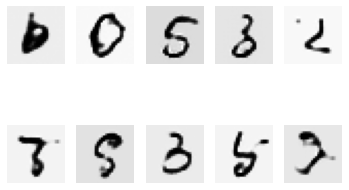

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.890625, 0.75, 0.0
1 / 100: 0.78125, 0.859375, 0.0
2 / 100: 0.7421875, 0.7109375, 0.0
3 / 100: 0.59375, 0.703125, 0.0
4 / 100: 0.8203125, 0.7421875, 0.0
5 / 100: 0.6484375, 0.90625, 0.0
6 / 100: 0.90625, 0.8046875, 0.0
7 / 100: 0.7109375, 0.96875, 0.00390625
8 / 100: 0.8125, 0.6796875, 0.0
9 / 100: 0.640625, 0.8359375, 0.0
10 / 100: 0.828125, 0.6015625, 0.0
11 / 100: 0.6171875, 0.8046875, 0.0
12 / 100: 0.7109375, 0.828125, 0.00390625
13 / 100: 0.7109375, 0.796875, 0.0
14 / 100: 0.8125, 0.7734375, 0.0
15 / 100: 0.578125, 0.671875, 0.0
16 / 100: 0.7421875, 0.8203125, 0.0
17 / 100: 0.7421875, 0.625, 0.0
18 / 100: 0.515625, 0.8046875, 0.0
19 / 100: 0.765625, 0.484375, 0.00390625
20 / 100: 0.4765625, 0.8984375, 0.0
21 / 100: 0.796875, 0.8984375, 0.0
22 / 100: 0.890625, 0.4453125, 0.0
23 / 100: 0.40625, 0.9921875, 0.0
24 / 100: 0.9296875, 0.6875, 0.0
25 / 100: 0.796875, 0.6796875, 0.0
26 / 100: 0.5703125, 0.

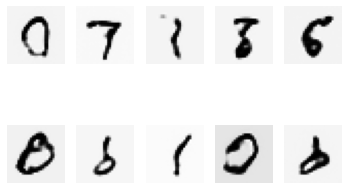

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.5390625, 0.0
1 / 100: 0.640625, 0.890625, 0.0
2 / 100: 0.6640625, 0.734375, 0.0
3 / 100: 0.7578125, 0.5625, 0.00390625
4 / 100: 0.546875, 0.7109375, 0.0
5 / 100: 0.53125, 0.9609375, 0.0
6 / 100: 0.84375, 0.2578125, 0.0
7 / 100: 0.6484375, 0.984375, 0.0
8 / 100: 0.8359375, 0.609375, 0.00390625
9 / 100: 0.71875, 0.5859375, 0.0078125
10 / 100: 0.5, 0.734375, 0.0
11 / 100: 0.6328125, 1.0, 0.0
12 / 100: 0.96875, 0.28125, 0.00390625
13 / 100: 0.4765625, 1.0, 0.0
14 / 100: 0.9609375, 0.8125, 0.00390625
15 / 100: 0.9609375, 0.8203125, 0.0
16 / 100: 0.59375, 1.0, 0.0
17 / 100: 1.0, 0.9921875, 0.0
18 / 100: 1.0, 0.3203125, 0.0
19 / 100: 0.6640625, 1.0, 0.0
20 / 100: 0.9375, 0.984375, 0.0
21 / 100: 0.9921875, 0.5859375, 0.0
22 / 100: 0.609375, 1.0, 0.0
23 / 100: 0.9609375, 0.828125, 0.0
24 / 100: 0.890625, 0.9140625, 0.0
25 / 100: 0.75, 0.984375, 0.0078125
26 / 100: 0.9765625, 0.984375, 0.0
27 / 100: 0.9921

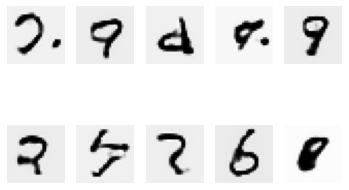

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 0.9453125, 0.0
1 / 100: 0.9921875, 1.0, 0.0
2 / 100: 0.8359375, 0.9453125, 0.0
3 / 100: 0.9921875, 0.5546875, 0.0
4 / 100: 0.4609375, 0.8359375, 0.00390625
5 / 100: 0.828125, 0.5, 0.0078125
6 / 100: 0.5625, 0.625, 0.0
7 / 100: 0.5390625, 0.96875, 0.0078125
8 / 100: 0.9140625, 0.3515625, 0.0
9 / 100: 0.34375, 0.984375, 0.00390625
10 / 100: 0.921875, 0.9921875, 0.00390625
11 / 100: 0.96875, 0.6640625, 0.0
12 / 100: 0.5546875, 1.0, 0.0
13 / 100: 0.9453125, 0.7734375, 0.0
14 / 100: 0.8984375, 0.5546875, 0.0
15 / 100: 0.4453125, 0.9921875, 0.0
16 / 100: 0.9453125, 0.5625, 0.0
17 / 100: 0.859375, 0.734375, 0.0
18 / 100: 0.4921875, 0.9921875, 0.00390625
19 / 100: 0.9921875, 0.984375, 0.0
20 / 100: 1.0, 0.640625, 0.0
21 / 100: 0.6953125, 1.0, 0.0
22 / 100: 0.9921875, 0.8515625, 0.0
23 / 100: 0.9453125, 0.859375, 0.0
24 / 100: 0.6796875, 1.0, 0.0
25 / 100: 1.0, 0.9609375, 0.0
26 / 100: 0.984375, 0.546

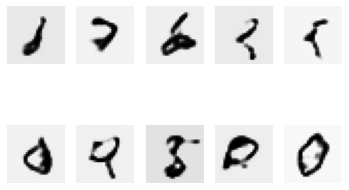

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.984375, 0.53125, 0.0
1 / 100: 0.734375, 0.515625, 0.0
2 / 100: 0.4375, 0.984375, 0.00390625
3 / 100: 0.90625, 0.875, 0.0
4 / 100: 0.890625, 0.5, 0.0
5 / 100: 0.3828125, 0.9921875, 0.0
6 / 100: 0.984375, 0.5, 0.00390625
7 / 100: 0.84375, 0.796875, 0.0078125
8 / 100: 0.328125, 0.984375, 0.0078125
9 / 100: 0.984375, 0.375, 0.0
10 / 100: 0.65625, 0.4375, 0.00390625
11 / 100: 0.375, 0.9609375, 0.0
12 / 100: 0.8828125, 0.765625, 0.00390625
13 / 100: 0.8203125, 0.578125, 0.0
14 / 100: 0.5234375, 0.9765625, 0.0
15 / 100: 0.90625, 0.8125, 0.0
16 / 100: 0.7890625, 0.4921875, 0.0
17 / 100: 0.4140625, 0.9921875, 0.0
18 / 100: 0.96875, 0.515625, 0.0
19 / 100: 0.6015625, 0.71875, 0.0
20 / 100: 0.5078125, 0.9765625, 0.00390625
21 / 100: 0.9609375, 0.4296875, 0.0
22 / 100: 0.6171875, 0.75, 0.00390625
23 / 100: 0.5859375, 0.9453125, 0.0
24 / 100: 0.8125, 0.6640625, 0.0
25 / 100: 0.8359375, 0.7265625, 0.0
26 / 100: 0.4

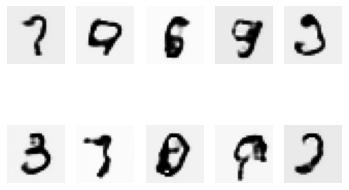

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9375, 0.9921875, 0.0
1 / 100: 0.96875, 0.875, 0.0
2 / 100: 0.953125, 0.8125, 0.0
3 / 100: 0.4296875, 0.453125, 0.0234375
4 / 100: 0.8359375, 0.421875, 0.0
5 / 100: 0.28125, 0.6015625, 0.01171875
6 / 100: 0.796875, 0.609375, 0.00390625
7 / 100: 0.484375, 0.328125, 0.00390625
8 / 100: 0.453125, 0.8203125, 0.0
9 / 100: 0.484375, 1.0, 0.0
10 / 100: 0.9921875, 0.3203125, 0.0
11 / 100: 0.4140625, 1.0, 0.0
12 / 100: 0.9609375, 0.359375, 0.0
13 / 100: 0.5625, 0.984375, 0.0
14 / 100: 0.8125, 0.9140625, 0.0
15 / 100: 0.7421875, 0.9140625, 0.0
16 / 100: 0.8515625, 0.6484375, 0.0
17 / 100: 0.5234375, 0.984375, 0.00390625
18 / 100: 0.96875, 0.5703125, 0.0
19 / 100: 0.53125, 0.875, 0.0
20 / 100: 0.875, 0.640625, 0.0
21 / 100: 0.6640625, 0.578125, 0.0
22 / 100: 0.640625, 0.9140625, 0.0
23 / 100: 0.8046875, 0.953125, 0.0
24 / 100: 0.8828125, 0.765625, 0.00390625
25 / 100: 0.71875, 0.9453125, 0.0
26 / 100: 0.7890625, 

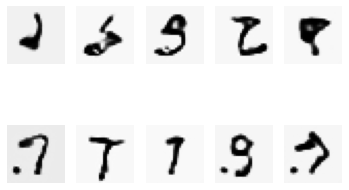

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.359375, 0.9609375, 0.0
1 / 100: 0.8046875, 0.9375, 0.0
2 / 100: 0.8828125, 0.40625, 0.0
3 / 100: 0.4375, 1.0, 0.0
4 / 100: 0.96875, 0.4921875, 0.0
5 / 100: 0.7890625, 0.6875, 0.0
6 / 100: 0.34375, 0.9609375, 0.0
7 / 100: 0.890625, 0.8984375, 0.00390625
8 / 100: 0.9140625, 0.4921875, 0.0
9 / 100: 0.453125, 1.0, 0.0
10 / 100: 0.984375, 0.3671875, 0.0
11 / 100: 0.5859375, 0.7578125, 0.0
12 / 100: 0.4609375, 0.9609375, 0.0
13 / 100: 0.8125, 0.578125, 0.0
14 / 100: 0.8125, 0.75, 0.00390625
15 / 100: 0.53125, 1.0, 0.0
16 / 100: 0.9609375, 0.3203125, 0.0
17 / 100: 0.75, 0.90625, 0.0
18 / 100: 0.4765625, 0.9453125, 0.0
19 / 100: 0.9296875, 0.4296875, 0.00390625
20 / 100: 0.6171875, 0.9375, 0.0
21 / 100: 0.84375, 0.7265625, 0.0
22 / 100: 0.7578125, 0.8046875, 0.0
23 / 100: 0.65625, 0.90625, 0.0
24 / 100: 0.7265625, 0.796875, 0.0
25 / 100: 0.8359375, 0.59375, 0.0
26 / 100: 0.4140625, 0.984375, 0.0
27 / 100: 0.9

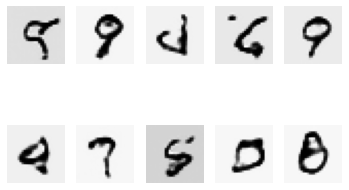

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8671875, 0.4453125, 0.0
1 / 100: 0.3671875, 0.9921875, 0.0
2 / 100: 0.953125, 0.5625, 0.0
3 / 100: 0.796875, 0.71875, 0.00390625
4 / 100: 0.4375, 1.0, 0.0
5 / 100: 0.984375, 0.640625, 0.0
6 / 100: 0.8359375, 0.7578125, 0.0
7 / 100: 0.4140625, 1.0, 0.00390625
8 / 100: 0.96875, 0.4140625, 0.0
9 / 100: 0.625, 0.6328125, 0.0
10 / 100: 0.5, 0.9765625, 0.0
11 / 100: 0.9296875, 0.9375, 0.0
12 / 100: 0.96875, 0.4609375, 0.0
13 / 100: 0.2890625, 1.0, 0.0
14 / 100: 1.0, 0.5859375, 0.0
15 / 100: 0.84375, 0.90625, 0.0
16 / 100: 0.703125, 1.0, 0.0
17 / 100: 1.0, 0.9921875, 0.0
18 / 100: 1.0, 0.7265625, 0.0
19 / 100: 0.9765625, 1.0, 0.0
20 / 100: 0.9921875, 0.84375, 0.0
21 / 100: 0.9296875, 0.7578125, 0.0
22 / 100: 0.4609375, 1.0, 0.0
23 / 100: 1.0, 0.640625, 0.0
24 / 100: 0.8828125, 0.8515625, 0.00390625
25 / 100: 0.4765625, 1.0, 0.0
26 / 100: 1.0, 0.359375, 0.0
27 / 100: 0.6171875, 0.75, 0.00390625
28 / 100: 0.49

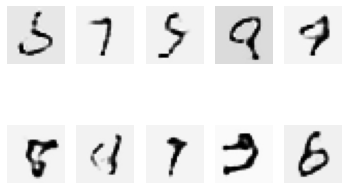

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.7734375, 0.5859375, 0.0
1 / 100: 0.265625, 0.9609375, 0.0078125
2 / 100: 0.953125, 0.734375, 0.0
3 / 100: 0.7890625, 0.4140625, 0.0
4 / 100: 0.390625, 0.9765625, 0.0
5 / 100: 0.9609375, 0.4765625, 0.0
6 / 100: 0.6796875, 0.53125, 0.0078125
7 / 100: 0.390625, 0.9375, 0.00390625
8 / 100: 0.8828125, 0.875, 0.0
9 / 100: 0.8984375, 0.3671875, 0.0
10 / 100: 0.4296875, 1.0, 0.0
11 / 100: 0.96875, 0.6484375, 0.0
12 / 100: 0.796875, 0.59375, 0.0
13 / 100: 0.578125, 0.9609375, 0.0
14 / 100: 0.75, 0.953125, 0.0
15 / 100: 0.9765625, 0.4921875, 0.00390625
16 / 100: 0.296875, 1.0, 0.0
17 / 100: 1.0, 0.5703125, 0.0
18 / 100: 0.796875, 0.71875, 0.0
19 / 100: 0.3671875, 0.9765625, 0.0
20 / 100: 0.9609375, 0.734375, 0.0
21 / 100: 0.890625, 0.5703125, 0.0
22 / 100: 0.3203125, 1.0, 0.0
23 / 100: 0.9921875, 0.4921875, 0.0
24 / 100: 0.71875, 0.59375, 0.0
25 / 100: 0.4140625, 0.9921875, 0.0
26 / 100: 0.9765625, 0.9140625, 0

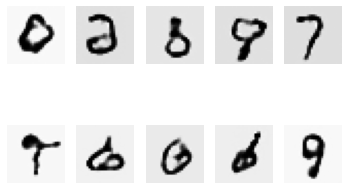

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8125, 0.6484375, 0.0
1 / 100: 0.4921875, 0.9453125, 0.0
2 / 100: 0.9140625, 0.59375, 0.0
3 / 100: 0.640625, 0.953125, 0.00390625
4 / 100: 0.84375, 1.0, 0.0
5 / 100: 0.984375, 1.0, 0.0
6 / 100: 0.9921875, 0.9375, 0.0
7 / 100: 1.0, 0.890625, 0.0
8 / 100: 0.6796875, 1.0, 0.00390625
9 / 100: 0.9296875, 0.984375, 0.0
10 / 100: 0.953125, 1.0, 0.0
11 / 100: 0.984375, 0.8046875, 0.00390625
12 / 100: 0.7890625, 0.890625, 0.00390625
13 / 100: 0.671875, 0.875, 0.01171875
14 / 100: 0.9609375, 0.328125, 0.0
15 / 100: 0.25, 0.3359375, 0.0
16 / 100: 0.4375, 0.9375, 0.0
17 / 100: 0.96875, 0.25, 0.0
18 / 100: 0.234375, 0.984375, 0.0
19 / 100: 0.8984375, 0.6953125, 0.0078125
20 / 100: 0.890625, 0.6484375, 0.0
21 / 100: 0.453125, 0.984375, 0.0
22 / 100: 0.953125, 0.4765625, 0.0
23 / 100: 0.625, 0.7578125, 0.0
24 / 100: 0.5546875, 0.9609375, 0.0
25 / 100: 0.9296875, 0.578125, 0.0
26 / 100: 0.6328125, 0.8359375, 0.0039062

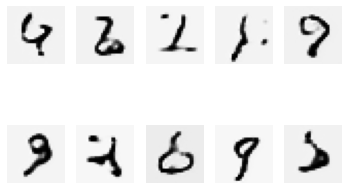

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4375, 0.9921875, 0.0
1 / 100: 0.90625, 0.4609375, 0.0
2 / 100: 0.6953125, 0.75, 0.0
3 / 100: 0.296875, 0.6015625, 0.01171875
4 / 100: 0.890625, 0.40625, 0.0
5 / 100: 0.3359375, 0.8828125, 0.00390625
6 / 100: 0.7578125, 0.3359375, 0.0
7 / 100: 0.53125, 0.7109375, 0.0
8 / 100: 0.4609375, 0.96875, 0.0
9 / 100: 0.9453125, 0.296875, 0.0
10 / 100: 0.421875, 0.9921875, 0.0
11 / 100: 0.8125, 0.890625, 0.0
12 / 100: 0.9609375, 0.6875, 0.0
13 / 100: 0.5234375, 0.9921875, 0.0
14 / 100: 0.9140625, 0.6796875, 0.00390625
15 / 100: 0.8828125, 0.7890625, 0.0
16 / 100: 0.359375, 0.9765625, 0.00390625
17 / 100: 0.953125, 0.5859375, 0.0
18 / 100: 0.6796875, 0.6015625, 0.00390625
19 / 100: 0.5390625, 0.875, 0.0
20 / 100: 0.78125, 0.8515625, 0.0
21 / 100: 0.796875, 0.46875, 0.0
22 / 100: 0.5, 1.0, 0.0
23 / 100: 0.90625, 0.7734375, 0.0
24 / 100: 0.8046875, 0.8515625, 0.00390625
25 / 100: 0.8203125, 0.9140625, 0.0
26 / 100:

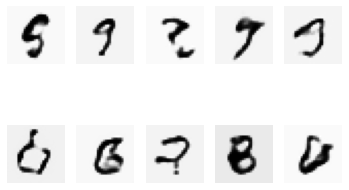

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.8515625, 0.484375, 0.0
1 / 100: 0.375, 0.9140625, 0.015625
2 / 100: 0.8828125, 0.546875, 0.00390625
3 / 100: 0.765625, 0.7109375, 0.0
4 / 100: 0.3515625, 0.9921875, 0.00390625
5 / 100: 0.9921875, 0.203125, 0.0
6 / 100: 0.4296875, 0.9140625, 0.0
7 / 100: 0.671875, 0.828125, 0.0078125
8 / 100: 0.828125, 0.4375, 0.0
9 / 100: 0.4765625, 0.9765625, 0.0
10 / 100: 0.8984375, 0.84375, 0.0
11 / 100: 0.875, 0.578125, 0.0
12 / 100: 0.34375, 0.9765625, 0.0
13 / 100: 0.9765625, 0.8125, 0.0
14 / 100: 0.828125, 0.453125, 0.0
15 / 100: 0.3671875, 0.9765625, 0.00390625
16 / 100: 0.875, 0.6171875, 0.00390625
17 / 100: 0.59375, 0.46875, 0.0
18 / 100: 0.453125, 0.9375, 0.0
19 / 100: 0.90625, 0.546875, 0.00390625
20 / 100: 0.6875, 0.8515625, 0.0
21 / 100: 0.59375, 0.8359375, 0.0
22 / 100: 0.875, 0.8359375, 0.0
23 / 100: 0.7421875, 0.7578125, 0.0
24 / 100: 0.6875, 0.984375, 0.0
25 / 100: 0.9375, 0.71875, 0.0
26 / 100: 0.82

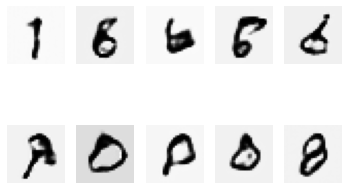

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.34375, 1.0, 0.0
1 / 100: 0.9921875, 0.2890625, 0.0
2 / 100: 0.6328125, 0.828125, 0.0
3 / 100: 0.5625, 0.9296875, 0.0
4 / 100: 0.9609375, 0.7578125, 0.0
5 / 100: 0.78125, 0.7890625, 0.0
6 / 100: 0.5625, 0.9375, 0.0
7 / 100: 0.8046875, 0.8203125, 0.0078125
8 / 100: 0.890625, 0.765625, 0.0
9 / 100: 0.3828125, 0.984375, 0.00390625
10 / 100: 0.96875, 0.546875, 0.0
11 / 100: 0.65625, 0.7109375, 0.0
12 / 100: 0.4921875, 0.8046875, 0.0
13 / 100: 0.7890625, 0.984375, 0.0
14 / 100: 0.9453125, 0.6875, 0.0
15 / 100: 0.6953125, 1.0, 0.0
16 / 100: 0.984375, 0.5078125, 0.0
17 / 100: 0.8203125, 0.9375, 0.0
18 / 100: 0.6015625, 0.9609375, 0.0
19 / 100: 0.90625, 0.5703125, 0.0
20 / 100: 0.6953125, 0.9609375, 0.0
21 / 100: 0.8515625, 0.6796875, 0.0
22 / 100: 0.7890625, 0.5078125, 0.0
23 / 100: 0.4296875, 1.0, 0.0
24 / 100: 0.953125, 0.90625, 0.0
25 / 100: 0.9453125, 0.75, 0.0
26 / 100: 0.5, 0.953125, 0.0
27 / 100: 0.945

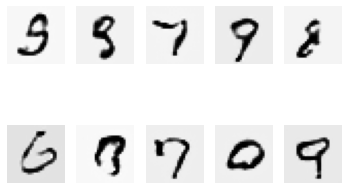

In [10]:
EVALUATION_ROUNDS = 50
BATCHES = 100
BATCH_SIZE = 256

# Lets get fresh copies of everything.
discriminator = create_discriminator(INPUT_SHAPE)
generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)
gan = create_gan(generator, discriminator)

for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 10 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 25600 samples:


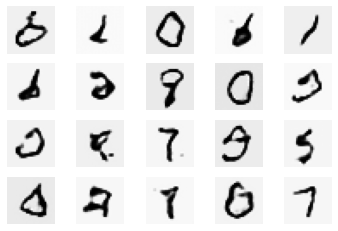


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 51200 samples:


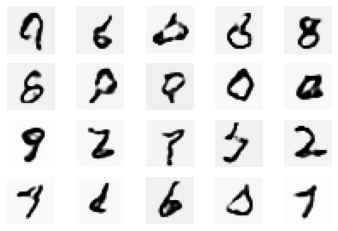


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 76800 samples:


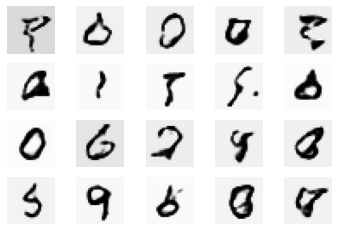


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 102400 samples:


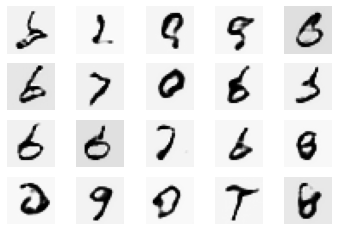


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 128000 samples:


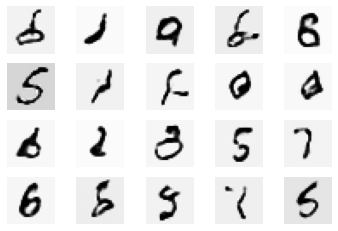


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 153600 samples:


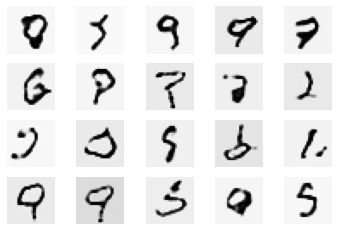


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 179200 samples:


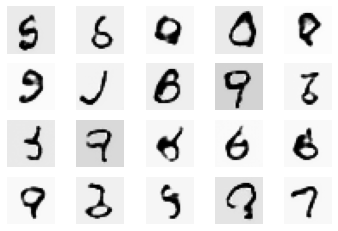


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 204800 samples:


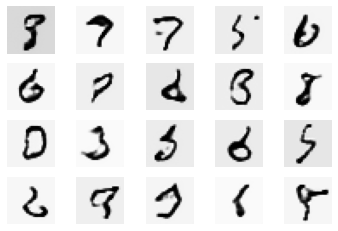


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 230400 samples:


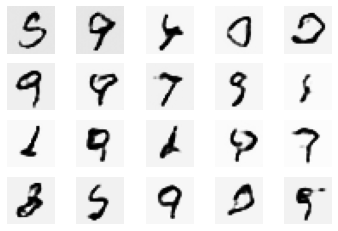


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 256000 samples:


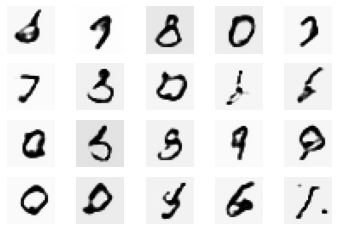


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 281600 samples:


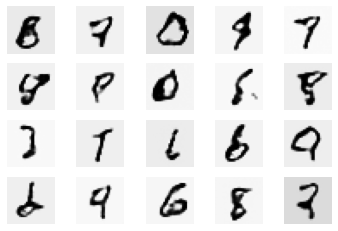


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 307200 samples:


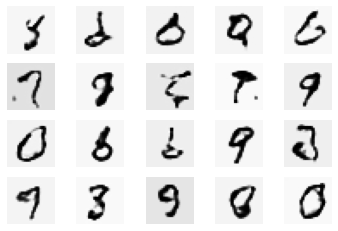


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 332800 samples:


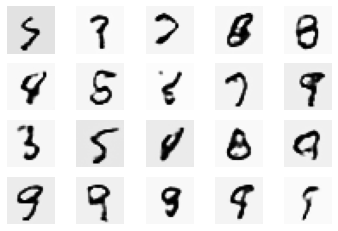


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 358400 samples:


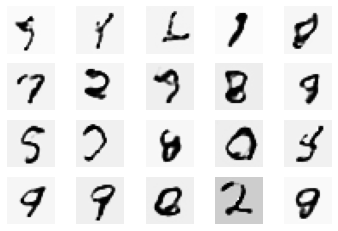


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 384000 samples:


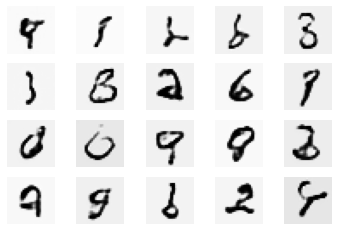


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 409600 samples:


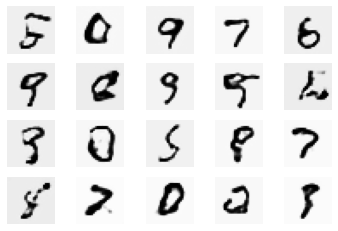


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 435200 samples:


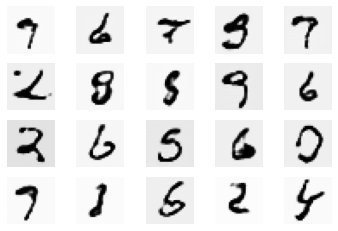


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 460800 samples:


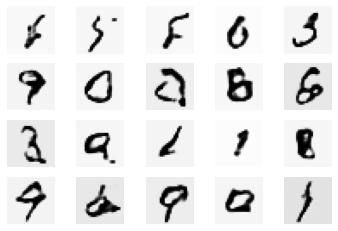


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 486400 samples:


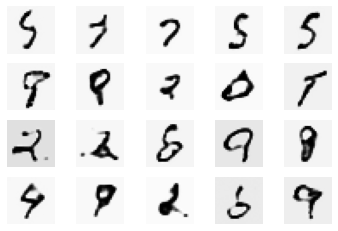


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 512000 samples:


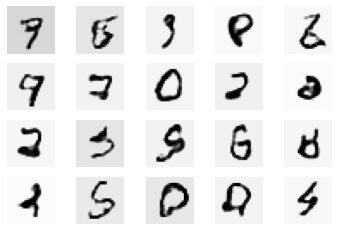


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 537600 samples:


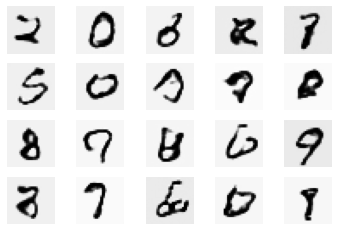


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 563200 samples:


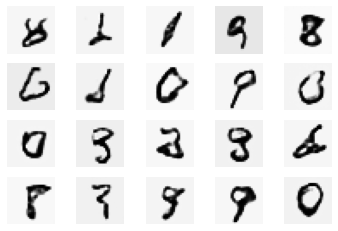


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 588800 samples:


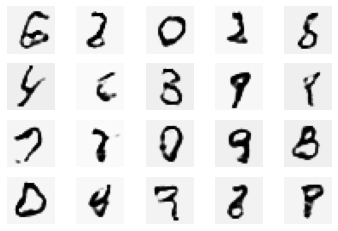


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 614400 samples:


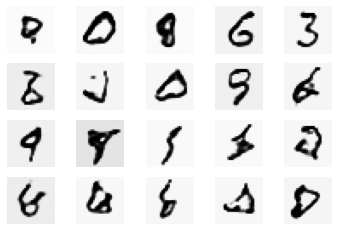


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 640000 samples:


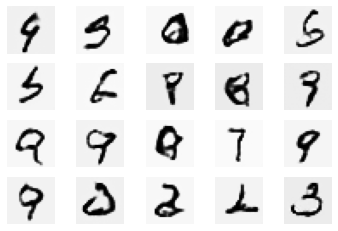


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 665600 samples:


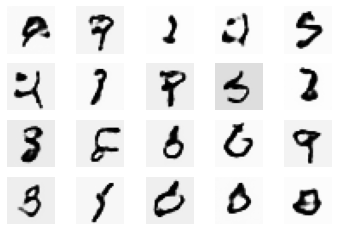


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 691200 samples:


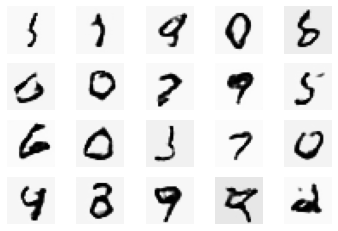


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 716800 samples:


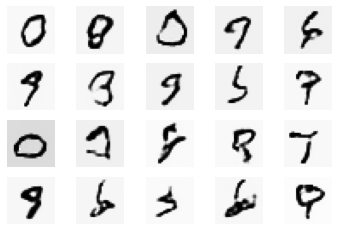


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 742400 samples:


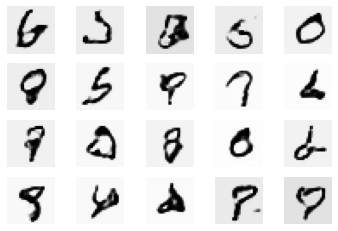


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 768000 samples:


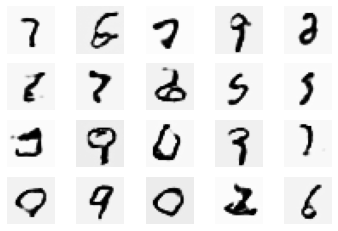


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 793600 samples:


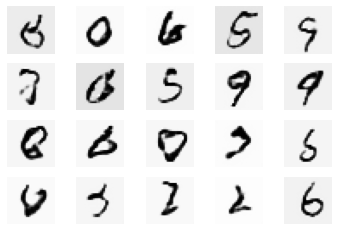


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 819200 samples:


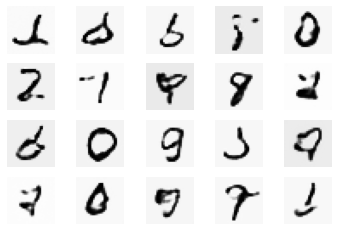


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 844800 samples:


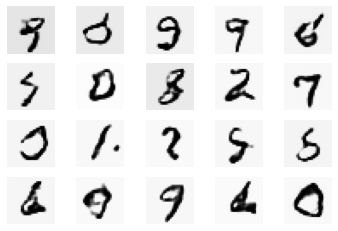


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 870400 samples:


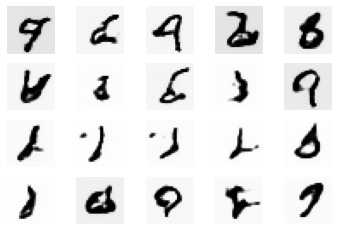


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 896000 samples:


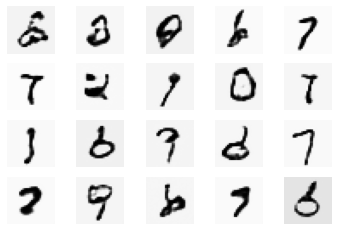


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 921600 samples:


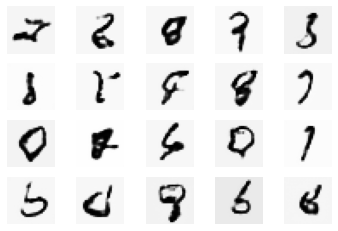


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 947200 samples:


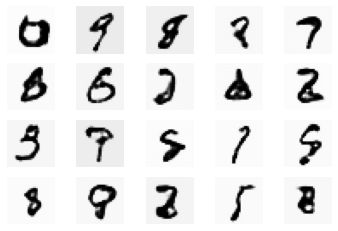


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 972800 samples:


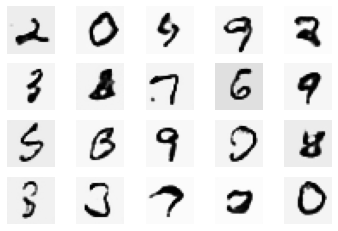


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 998400 samples:


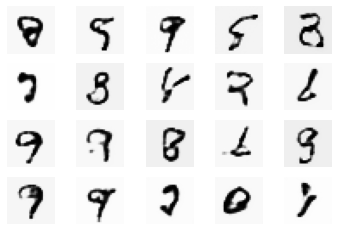


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1024000 samples:


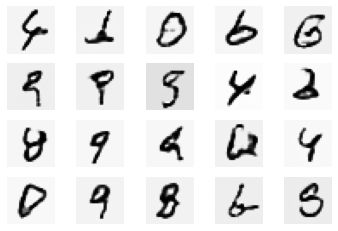


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1049600 samples:


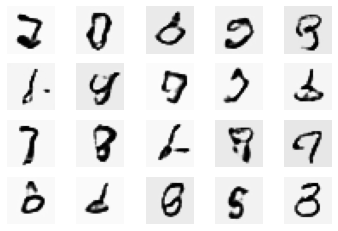


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1075200 samples:


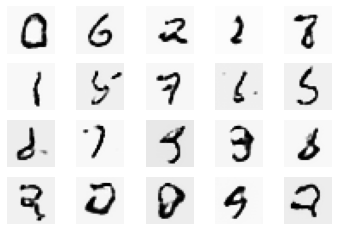


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1100800 samples:


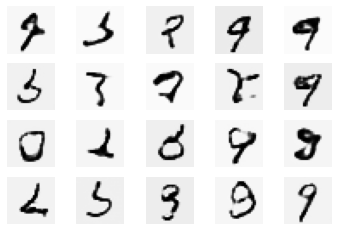


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1126400 samples:


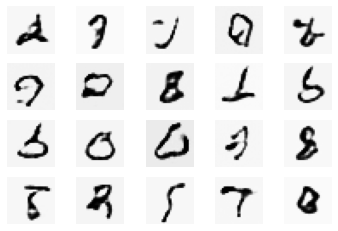


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1152000 samples:


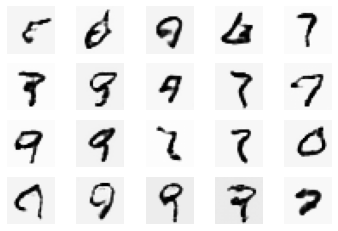


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1177600 samples:


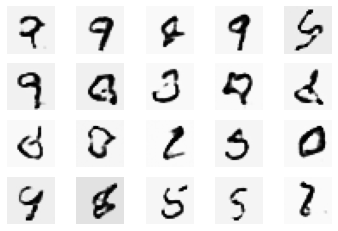


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1203200 samples:


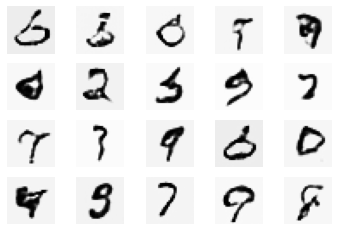


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1228800 samples:


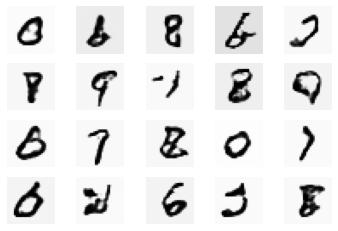


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1254400 samples:


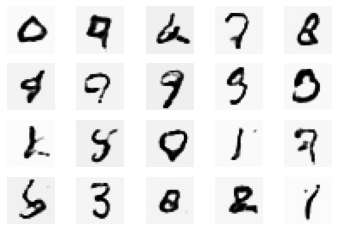


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1280000 samples:


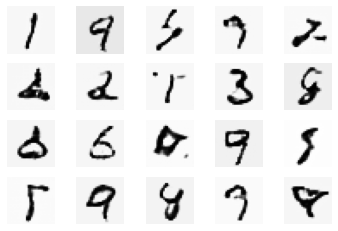

In [11]:
for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE, verbose=False)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 20 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()
    print()

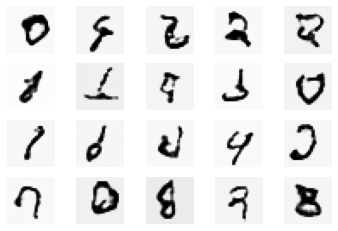

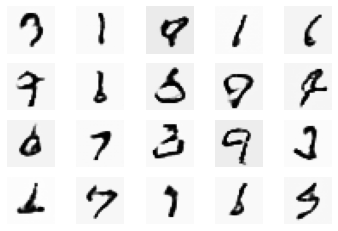

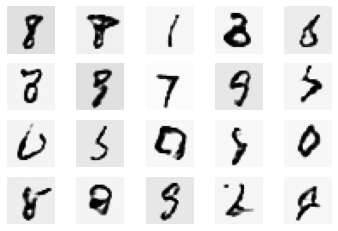

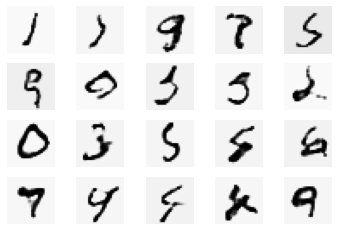

In [12]:
# And, after training on ~2.5M samples, lets look at a larger selection
# of generated digits.
for j in range(4):
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')
    
    plt.show()

In [13]:
generator.save('saved_models/mnist_gen_final.h5')
discriminator.save('saved_models/mnist_discriminator_final.h5')